## Naive approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [17]:
plt.rcParams["figure.figsize"] = (25,15)
plt.rcParams.update({'font.size': 22})

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

In [4]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [11]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0, parse_dates=True)

## EDA and plots

In [12]:
homes1 = homes.copy()


In [18]:
homes1['hour'] = homes1.index.hour
homes1['weekday'] = homes1.index.weekday
avg= homes1.groupby(['hour','weekday']).mean()['total_f']
avg = avg.reset_index()
avg_pivot= avg.pivot("hour","weekday","total_f")
avg_pivot.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

Text(0.5, 1.0, 'Average weekly electricity consumption in House F (in kWh)')

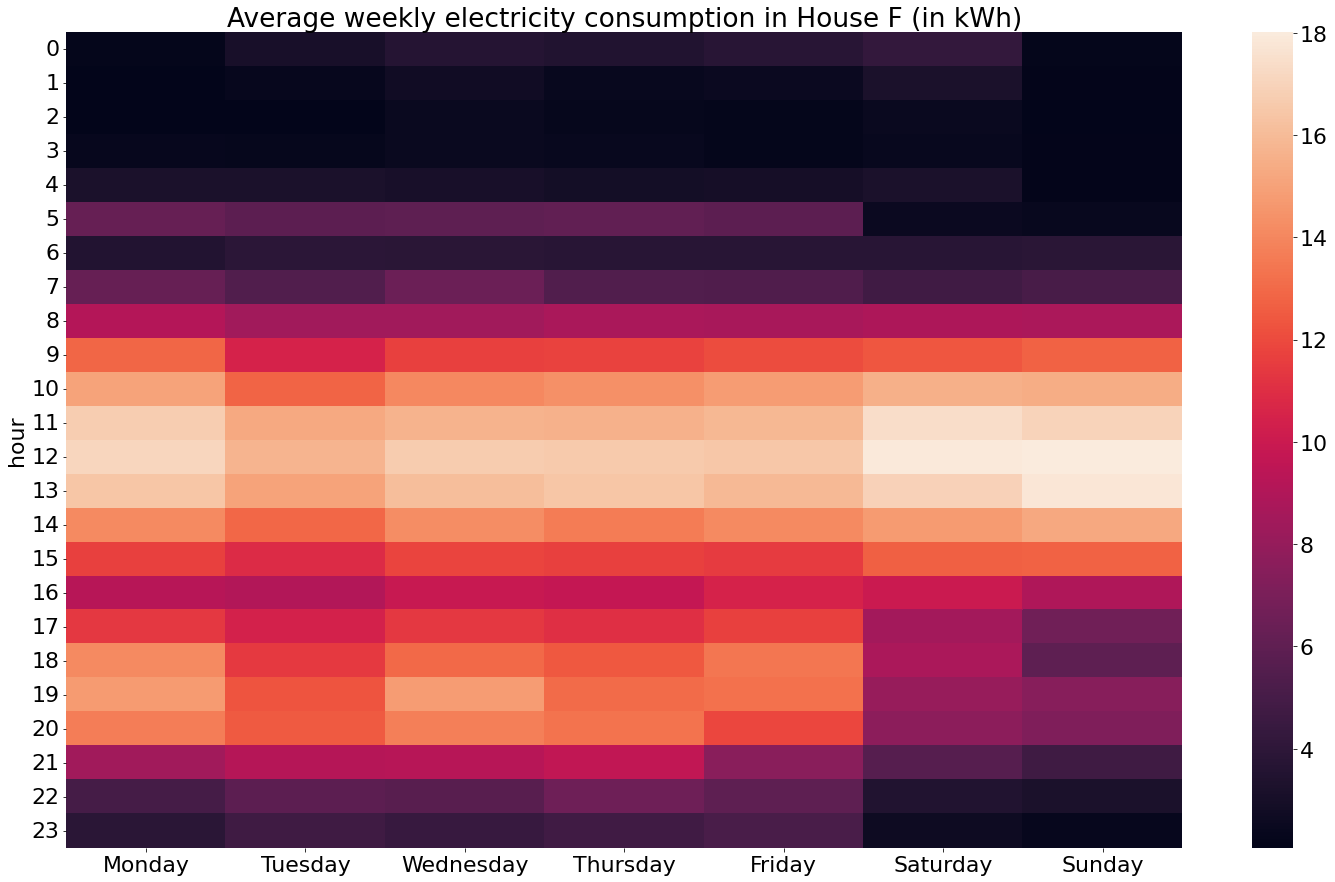

In [19]:
g=sns.heatmap(avg_pivot)
locs, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.title("Average weekly electricity consumption in House F (in kWh)")

## Examples

In [336]:
energy= homes['total_a']
energy= energy.dropna()
energy = energy.values
energy= energy.reshape(len(energy),1)

In [337]:
# Data partitining 
train_size  = int(len(energy) * 0.80)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [338]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [339]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [342]:
timesteps = 1 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(14090, 1, 1)

In [343]:
model = Sequential()
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [344]:
# Training
history= model.fit(X_train, y_train, epochs=110, batch_size=24, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/110


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7ff67f2e1940>
Traceback (most recent call last):
  File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


588/588 - 6s - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0075 - val_mse: 0.0075 - 6s/epoch - 11ms/step
Epoch 2/110
588/588 - 2s - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0071 - val_mse: 0.0071 - 2s/epoch - 3ms/step
Epoch 3/110
588/588 - 2s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0070 - val_mse: 0.0070 - 2s/epoch - 3ms/step
Epoch 4/110
588/588 - 2s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0070 - val_mse: 0.0070 - 2s/epoch - 3ms/step
Epoch 5/110
588/588 - 3s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0070 - val_mse: 0.0070 - 3s/epoch - 4ms/step
Epoch 6/110
588/588 - 2s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0069 - val_mse: 0.0069 - 2s/epoch - 4ms/step
Epoch 7/110


In [284]:
pred_train ={}
pred_test = {}

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

# pred_train["simple_lstm"] = scaler.inverse_transform(
#                               model.predict(X_train,verbose=0)).flatten()

# pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

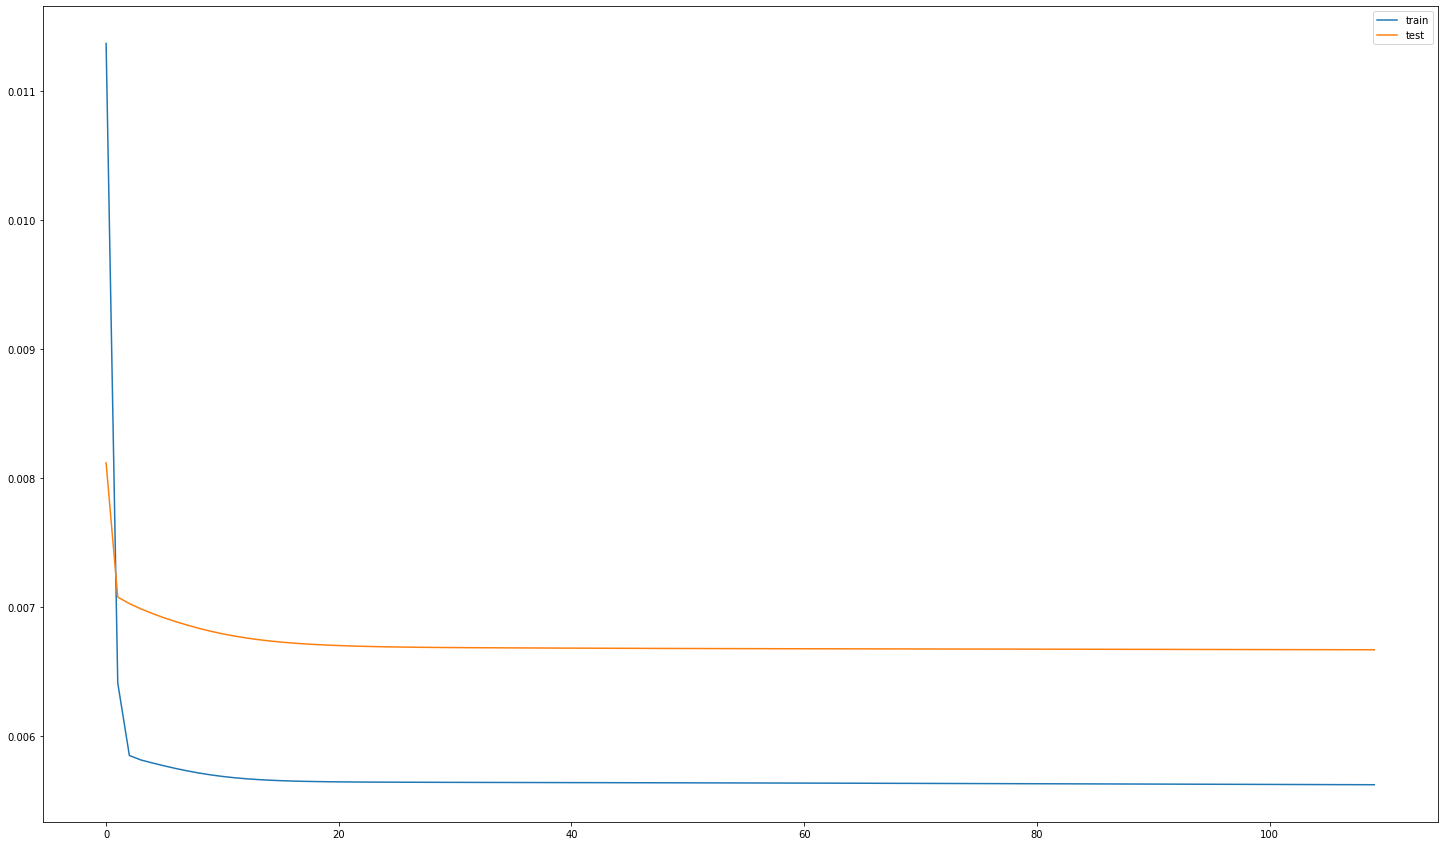

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

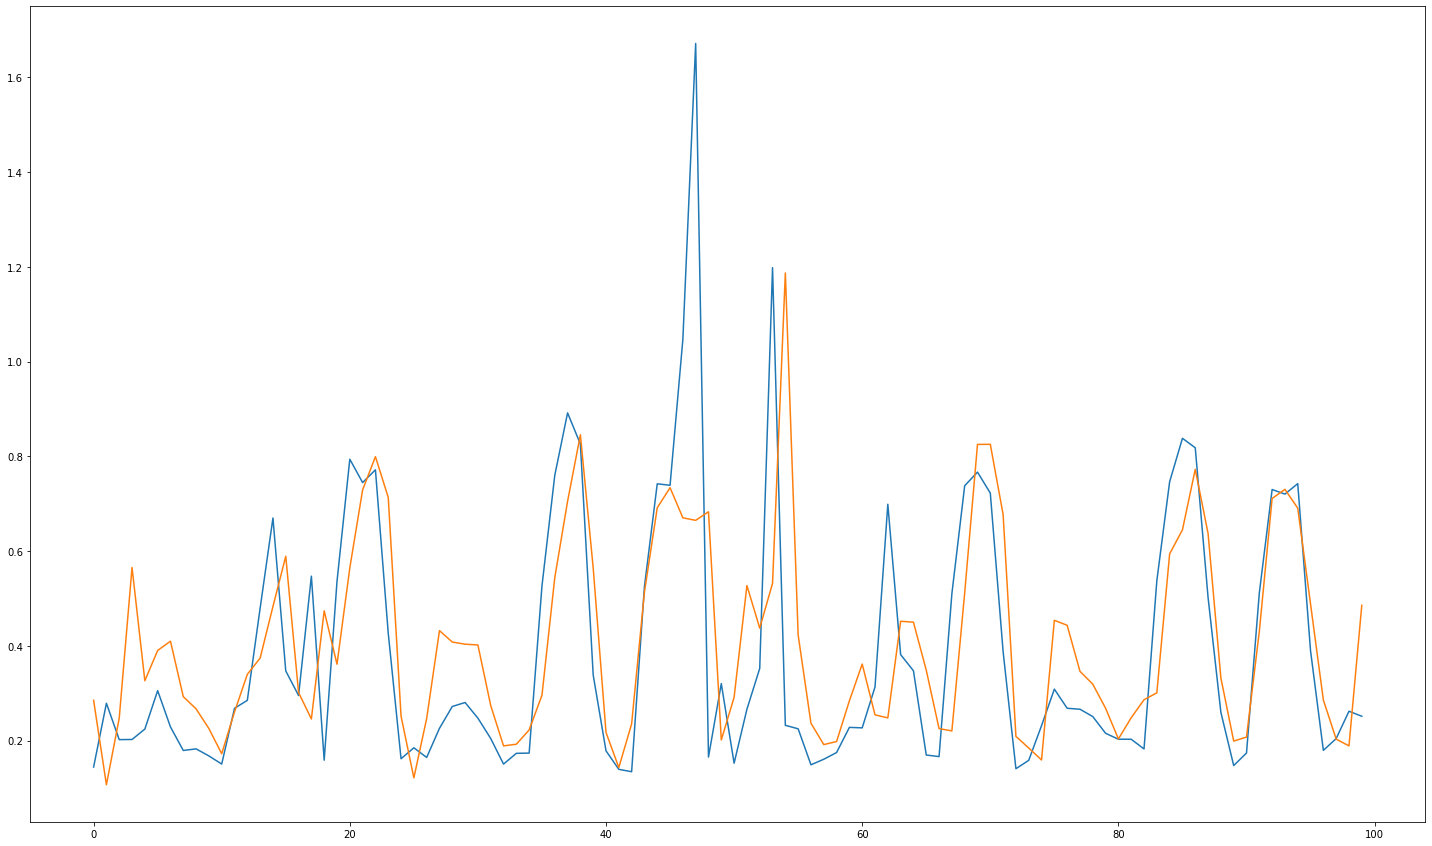

In [ ]:
# plt.plot(pred_train['true'])
# plt.plot(pred_train['simple_lstm'])

plt.plot(pred_test['true'][0:100])
plt.plot(pred_test['simple_lstm'][0:100])
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [ ]:
rmse_train={}
rmse_test={}

In [ ]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["simple_lstm"])

In [ ]:
rmse_test

{'naive': 0.2583147014240696}

## Example 2

In [275]:
def prepare_task(home, prop=0.8):

    home= home.dropna()
    home = home.values
    home= home.reshape(len(home),1)
    return home

    # # Data partitining 
    # train_size  = int(len(home) * prop)
    # test_size   = len(home) - train_size
    # train, test = energy[:train_size], energy[train_size:]



    # # The LSTM input layer must be 3D
    # # Create the dataset with rolling window for the training set and test set
    # X_train, y_train  = create_dataset(train, timesteps)  # lookback
    # X_test, y_test    = create_dataset(test, timesteps)

In [276]:
energy1= homes['total_a']
energy1= prepare_task(energy1)

In [277]:
train, test = train_test_split(energy1, train_size=0.8, shuffle=False)

In [278]:
def scale(train, test):

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    return train, test

In [279]:
train, test = scale(train, test)

In [280]:
timesteps= 13
# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [282]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(128, return_sequences=True))
#stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(128, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [283]:
history1=stateless_multilayer.fit(X_train, y_train, batch_size=64,epochs=10, validation_split=0.3)

Epoch 1/10
154/154 [==============================] - 18s 60ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 2/10
154/154 [==============================] - 8s 50ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 3/10
154/154 [==============================] - 8s 49ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4/10
154/154 [==============================] - 8s 52ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 5/10
154/154 [==============================] - 8s 49ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 6/10
154/154 [==============================] - 8s 50ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7/10
154/154 [==============================] - 7s 48ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 8/10
154/154 [==============================] - 8s 49ms/step -

In [285]:
pred_train["multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)).flatten()

pred_test['multilayer'] = scaler.inverse_transform(stateless_multilayer.predict(X_test)).flatten()

In [286]:
pred_test = pd.DataFrame(pred_test)

<AxesSubplot:>

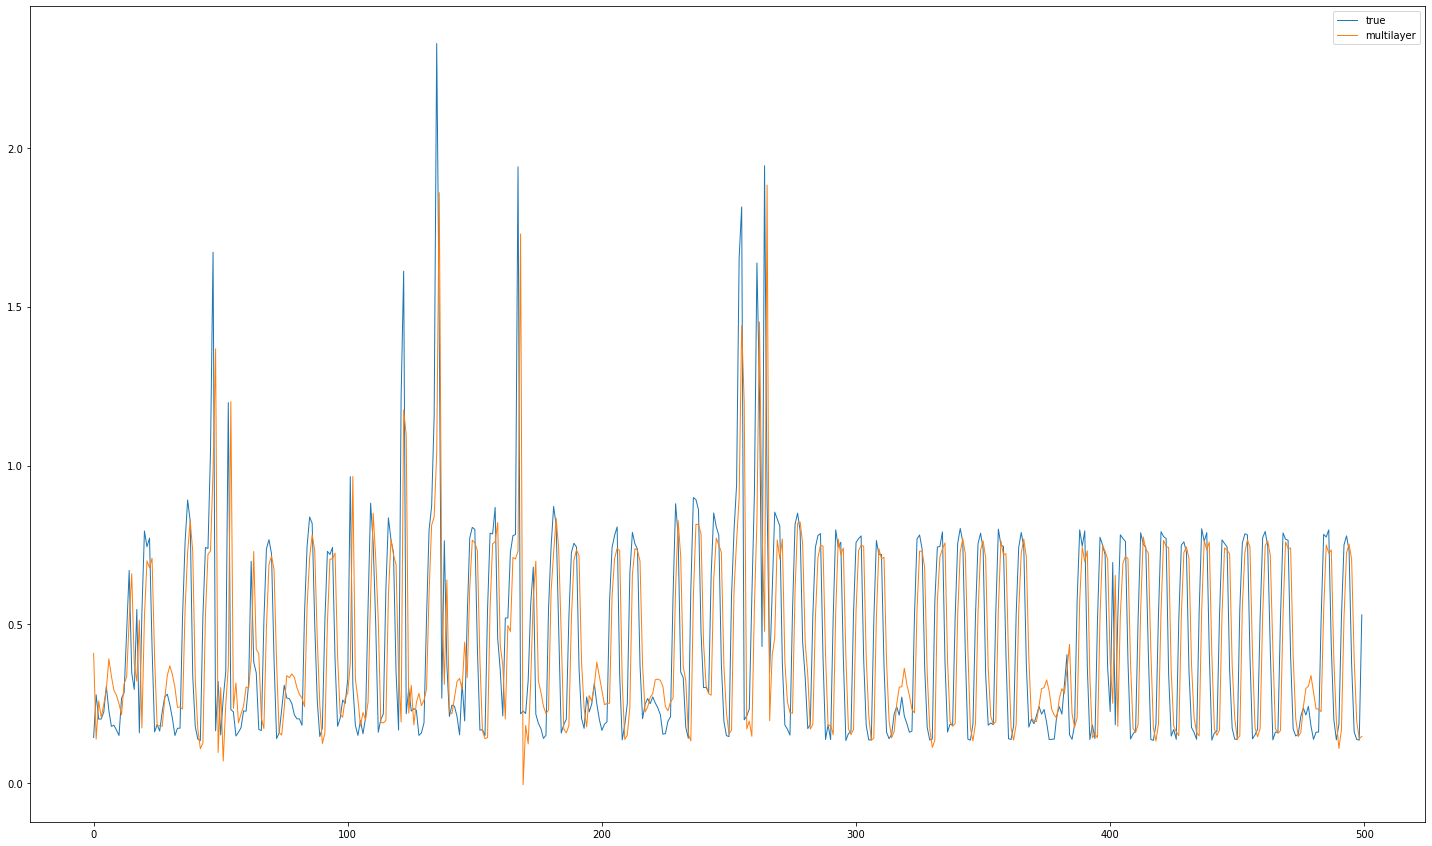

In [288]:
pd.DataFrame(pred_test).iloc[0:500].plot(lw=1)

In [289]:
rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["multilayer"])

In [290]:
rmse_train

{'single_total_a': 0.24586459426347226,
 'single_total_b': 0.24137703465015523,
 'single_total_c': 0.15190135781162026,
 'single_total_d': 0.278127919439027,
 'single_total_f': 0.09292062647619037,
 'single_total_g': 0.1963359660561293,
 'single_total_h': 0.28856279229770704,
 'stateless_multilayer': 0.24378655636337146}

In [291]:
rmse_test

{'single_total_a': 0.24839842549944394,
 'single_total_b': 0.11798655243622914,
 'single_total_c': 0.22970875539294386,
 'single_total_d': 0.2679475199399004,
 'single_total_f': 0.11408021280979261,
 'single_total_g': 0.2890687168046696,
 'single_total_h': 0.32117643335017937,
 'stateless_multilayer': 0.2901947215482246}

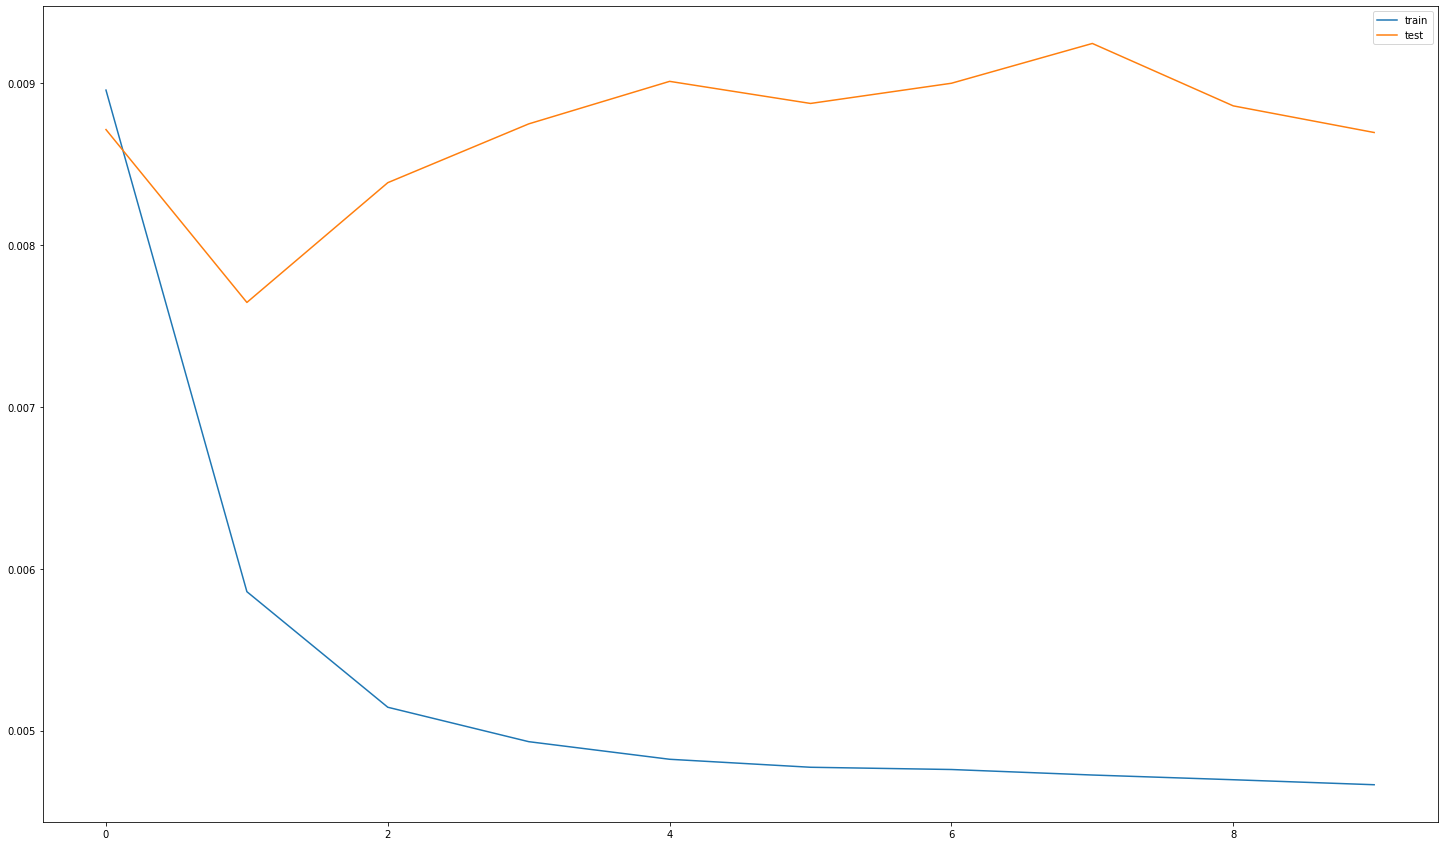

In [292]:
# plot history
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

## Multivariate Time Series forecasting with LSTMS

The approach for multivariate Time series forecasting consists of using a lagged version of all features to predict the present value of the target variable

In [372]:
example = homes

In [373]:
values = example.values
values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [374]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [375]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [376]:
itercols = [col for col in reframed.columns if '(t)' in col]
cols1 = [col for col in reframed.columns if '(t-' in col]

In [377]:
home_b = reframed.iloc[:,[1,2,4,8]]

<AxesSubplot:ylabel='Date & Time'>

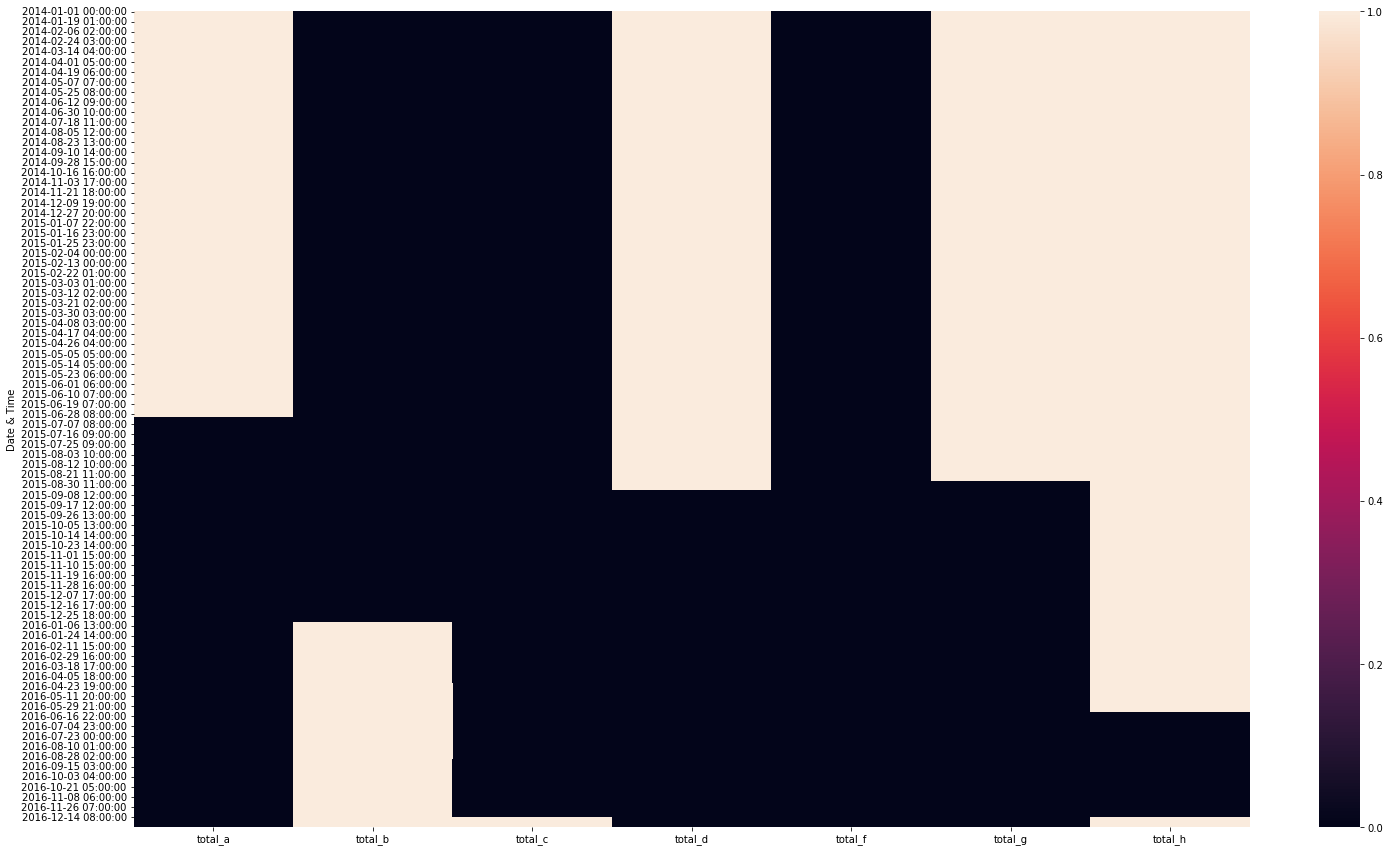

In [378]:
import seaborn as sns
sns.heatmap(homes.isna())

In [446]:
home_b= home_b.dropna()

In [447]:
# split into train and test sets
values = home_b.values

train, test = train_test_split(values, train_size=0.9, shuffle=False)


In [448]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [449]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test =test[:, :-1], test[:,-1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23651, 1, 3) (23651,) (2628, 1, 3) (2628,)


In [450]:
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [451]:
# fit network
history2 = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, shuffle=False, validation_data=(X_test, y_test))


Epoch 1/10
370/370 [==============================] - 7s 8ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0466 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0208
Epoch 2/10
370/370 [==============================] - 2s 7ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0407 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0209
Epoch 3/10
370/370 [==============================] - 3s 7ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0406 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0207
Epoch 4/10
370/370 [==============================] - 3s 8ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0404 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0204
Epoch 5/10
370/370 [==============================] - 3s 8ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0403 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0201
Epoch 6/10
370/370 [==============================] - 3s 8ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0402 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0199
Epoch 7/10
370/3

In [456]:
#Predict model
yhat= model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((X_test, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,-1]
#Invert scaling for actual 
y_test = y_test.reshape(len(y_test),1)
inv_y= np.concatenate((X_test, y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,-1]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

print("Test RMSE %.3f" % rmse)

ValueError: in user code:

    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_65" is incompatible with the layer: expected shape=(None, 1, 3), found shape=(None, 3)


In [452]:
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error


In [453]:
multi_train ={}
multi_test ={}

multi_error_train = {}
multi_error_test = {}

In [454]:
#Predict on both sets
yhat_test= model.predict(X_test)
yhat_train = model.predict(X_train)

#Reshape them to fit the right format to inverse_transform
X_train = X_train.reshape((X_train.shape[0],X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))

inv_yhat_test= np.concatenate((X_test, yhat_test), axis=1)
inv_yhat_train=np.concatenate((X_train, yhat_train), axis=1)

inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)

multi_test['multi'] = inv_yhat_test[:,-1]
multi_train['multi'] = inv_yhat_train[:,-1]

#Invert scaling for actual 
y_test = y_test.reshape(len(y_test),1)
y_train = y_train.reshape(len(y_train),1)

inv_y_test= np.concatenate((X_test, y_test), axis=1)
inv_y_train= np.concatenate((X_train, y_train), axis=1)

inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_train = scaler.inverse_transform(inv_y_train)

multi_test['true'] = inv_y_test[:,-1]
multi_train['true'] = inv_y_train[:,-1]


multi_error_test['multi'] = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
multi_error_train['multi'] = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))


In [436]:
multi_train['true'] = inv_y_train
multi_test['true'] = inv_y_test

multi_train['multi'] = inv_yhat_train
multi_test['multi'] = inv_yhat_test


In [455]:
print(f"The RMSE in the train set is : {multi_error_train}")
print(f"The RMSE in the test set is : {multi_error_test}")

The RMSE in the train set is : {'multi': 0.7082879}
The RMSE in the test set is : {'multi': 0.34281126}


In [ ]:

pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                            model.predict(X_train,verbose=0)).flatten()

pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#plot the predictions
plt.plot(pred_test[f'true_{home.name}'])
plt.plot(pred_test[f'simple_lstm_{home.name}'])
plt.show()


rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])


print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")


In [469]:
def train_multi_model(df, train_size = 0.9, neurons = 256, epochs=50, batch_size=64):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean square'''
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=["mean_squared_error", "mean_absolute_error"])


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    # plot history
    plt.plot(history2.history['loss'], label='train')
    #plt.plot(history2.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #Predict on both sets
    yhat_test= model.predict(X_test)
    yhat_train = model.predict(X_train)

    #Reshape them to fit the right format to inverse_transform
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))

    inv_yhat_test= np.concatenate((X_test, yhat_test), axis=1)
    inv_yhat_train=np.concatenate((X_train, yhat_train), axis=1)

    inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)

    multi_test['multi'] = inv_yhat_test[:,-1]
    multi_train['multi'] = inv_yhat_train[:,-1]

    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    y_train = y_train.reshape(len(y_train),1)

    inv_y_test= np.concatenate((X_test, y_test), axis=1)
    inv_y_train= np.concatenate((X_train, y_train), axis=1)

    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_train = scaler.inverse_transform(inv_y_train)

    multi_test['true'] = inv_y_test[:,-1]
    multi_train['true'] = inv_y_train[:,-1]


    multi_error_test['multi'] = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
    multi_error_train['multi'] = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))

    multi_test = pd.DataFrame(multi_test)


    multi_test.plot()

    #return pred_test,rmse_test

    
    

    

    
    

In [34]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   home_1(t-1)  17613 non-null  float32
 1   home_2(t-1)  26280 non-null  float32
 2   home_3(t-1)  34679 non-null  float32
 3   home_4(t-1)  14445 non-null  float32
 4   home_5(t-1)  35063 non-null  float32
 5   home_6(t-1)  14845 non-null  float32
 6   home_7(t-1)  4545 non-null   float32
 7   home_1(t)    17614 non-null  float32
 8   home_2(t)    26280 non-null  float32
 9   home_3(t)    34679 non-null  float32
 10  home_4(t)    14446 non-null  float32
 11  home_5(t)    35064 non-null  float32
 12  home_6(t)    14846 non-null  float32
 13  home_7(t)    4545 non-null   float32
dtypes: float32(14)
memory usage: 1.9 MB


In [36]:
home_a = reframed.iloc[:,[0,2,3,4,5,7]]
home_b = reframed.iloc[:,[1,2,4,8]]
home_c = reframed.iloc[:,[1,2,4,9]]
home_d = reframed.iloc[:,[0,2,3,4,5,10]]
home_f = reframed.iloc[:,[1,2,4,11]]
home_g= reframed.iloc[:,[0,2,3,4,5,6,12]]
home_h = reframed.iloc[:,[0,2,3,4,5,6,13]]

In [37]:
trainhomes= [home_a, home_b, home_c,home_d, home_f, home_g, home_h]

In [471]:
multi_train ={}
multi_test ={}

multi_error_train = {}
multi_error_test = {}

(4089, 1, 6) (4089,) (455, 1, 6) (455,)
Epoch 1/10
64/64 - 4s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0737 - 4s/epoch - 56ms/step
Epoch 2/10
64/64 - 0s - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0602 - 321ms/epoch - 5ms/step
Epoch 3/10
64/64 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0556 - 309ms/epoch - 5ms/step
Epoch 4/10
64/64 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0552 - 309ms/epoch - 5ms/step
Epoch 5/10
64/64 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0549 - 296ms/epoch - 5ms/step
Epoch 6/10
64/64 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0547 - 404ms/epoch - 6ms/step
Epoch 7/10
64/64 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0544 - 480ms/epoch - 8ms/step
Epoch 8/10
64/64 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0541 - 476ms/epoch - 7ms

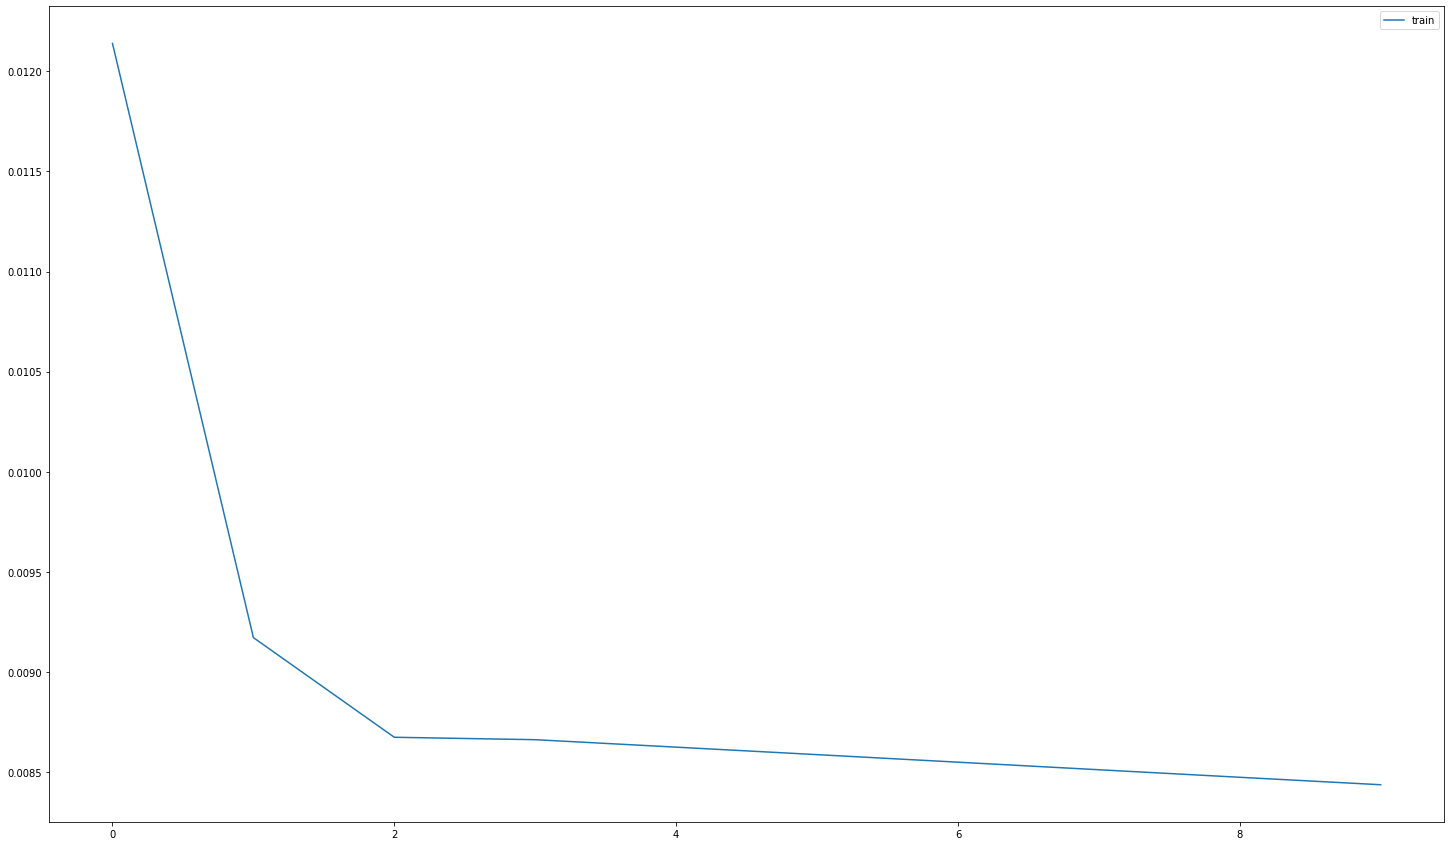

UnboundLocalError: local variable 'multi_test' referenced before assignment

In [472]:
train_multi_model(home_h, neurons=128, epochs=10)

In [ ]:
#Train all models (takes about 10 minutes)
[train_multi_model(home) for home in trainhomes]

## Training single LSTMS

In [ ]:
first=homes['total_a'].first_valid_index()
last= homes['total_a'].last_valid_index()


In [ ]:
sub_home = homes.loc[first:last,:]

In [ ]:
a=len(sub_home['total_a'].dropna())
c= len(sub_home['total_c'].dropna())

b= len(sub_home['total_b'].dropna())
d = len(sub_home['total_d'].dropna())
f = len(sub_home['total_f'].dropna())
g = len(sub_home['total_g'].dropna())
h = len(sub_home['total_h'].dropna())


print(a, b,c, d,f,g,h)

17614 8830 17229 14446 17614 14846 4545


In [ ]:
home_len=[a,b,c,d,f,g,h]
total_len = len(sub_home)

In [ ]:
home_len

[17614, 8830, 17229, 14446, 17614, 14846, 4545]

In [ ]:
for i in home_len:
    if (i/total_len)<0.8:
        print(" home %f is not viable"%i )

 home 8830.000000 is not viable
 home 4545.000000 is not viable


In [ ]:
sub_home= sub_home.drop(['total_b', "total_h"],axis=1)

In [ ]:
sub_home.dropna(inplace=True)

In [ ]:
nonna =homes.notnull().sum()
nonna= nonna.values
nonna= nonna.tolist()
df_length= len(homes)
weights= [x/df_length for x in nonna]

## Simple LSTM

In [354]:
pred_train ={}
pred_test={}

rmse_train ={}
rmse_test = {}

In [360]:
def run_model(home: pd.Series, train_size=0.8, timesteps= 1, epochs=50, batch_size= 64, neurons=128):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

    #Define the model
    model = Sequential()
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

    #Fit the data
    history= model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    


    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"simple_lstm_{home.name}"] = scaler.inverse_transform(
                                model.predict(X_train,verbose=0)).flatten()

    pred_test[f'simple_lstm_{home.name}'] = scaler.inverse_transform(model.predict(X_test)).flatten()

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #plot the predictions
    plt.plot(pred_test[f'true_{home.name}'])
    plt.plot(pred_test[f'simple_lstm_{home.name}'])
    plt.show()


    rmse_test[f'single_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'simple_lstm_{home.name}'])
    rmse_train[f'single_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'simple_lstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'single_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'single_{home.name}']}")




    


    

### Convolutional LSTM

In [ ]:
    # pred_train ={}
    # pred_test = {}

    # rmse_train ={}
    # rmse_test = {}

In [368]:
def run_conv_model(home: pd.Series, train_size, timesteps= 1, n_features=1, epochs=50, batch_size= 64, plot=False):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    print(X_train.shape)

   

    conv = Sequential()
    conv.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
    conv.add(MaxPooling1D(pool_size=1))
    conv.add(Flatten())
    conv.add(Dense(50, activation='relu'))
    conv.add(Dense(1))
    conv.compile(optimizer='adam', loss='mse')

    #Fit the data
    history= conv.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    
    # pred_train ={}
    # pred_test = {}

    # rmse_train ={}
    # rmse_test = {}

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error

    pred_train[f"true_{home.name}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
    pred_test[f"true_{home.name}"]  = scaler.inverse_transform(y_test).flatten() 

    pred_train[f"convlstm_{home.name}"] = scaler.inverse_transform(
                                conv.predict(X_train,verbose=0)).flatten()

    pred_test[f'convlstm_{home.name}'] = scaler.inverse_transform(conv.predict(X_test)).flatten()

    if plot==True:
        # plot history
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()

        #plot the predictions
        plt.plot(pred_test[f'true_{home.name}'])
        plt.plot(pred_test[f'convlstm_{home.name}'])
        plt.show()
    else:
        pass


    rmse_test[f'conv_{home.name}'] = rmse(pred_test[f'true_{home.name}'], pred_test[f'convlstm_{home.name}'])
    rmse_train[f'conv_{home.name}'] = rmse(pred_train[f'true_{home.name}'], pred_train[f'convlstm_{home.name}'])

  
    print(f"The RMSE in the train set is: {rmse_train[f'conv_{home.name}']}")
    print(f"The RMSE in the test set is: {rmse_test[f'conv_{home.name}']}")



    


    

In [318]:
timesteps =1
n_features=1 

In [303]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(homes['total_a'].dropna())
# plot_pacf(homes['total_a'].dropna())
# plt.show()


# for home in homes:

#     plot_pacf(homes[home].dropna())
# plt.show()

In [319]:
    #Drop nan values
home= homes['total_b'].dropna()

# train, test split
# split into train and test sets
values = home.values
values= values.reshape(len(values),1)
train, test = train_test_split(values, train_size=0.8, shuffle=False)

# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)


# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
print(X_train.shape)

(21023, 1, 1)


In [321]:
conv = Sequential()
conv.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
conv.add(MaxPooling1D(pool_size=1))
conv.add(Flatten())
conv.add(Dense(50, activation='relu'))
conv.add(Dense(1))
conv.compile(optimizer='adam', loss='mse')






In [322]:
#Fit the data
history= conv.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)



Epoch 1/50
329/329 - 1s - loss: 0.0072 - val_loss: 0.0030 - 1s/epoch - 3ms/step
Epoch 2/50
329/329 - 1s - loss: 0.0061 - val_loss: 0.0030 - 666ms/epoch - 2ms/step
Epoch 3/50
329/329 - 1s - loss: 0.0061 - val_loss: 0.0030 - 639ms/epoch - 2ms/step
Epoch 4/50
329/329 - 1s - loss: 0.0061 - val_loss: 0.0030 - 511ms/epoch - 2ms/step
Epoch 5/50
329/329 - 1s - loss: 0.0060 - val_loss: 0.0030 - 530ms/epoch - 2ms/step
Epoch 6/50
329/329 - 1s - loss: 0.0060 - val_loss: 0.0030 - 532ms/epoch - 2ms/step
Epoch 7/50
329/329 - 0s - loss: 0.0060 - val_loss: 0.0030 - 449ms/epoch - 1ms/step
Epoch 8/50
329/329 - 0s - loss: 0.0060 - val_loss: 0.0030 - 446ms/epoch - 1ms/step
Epoch 9/50
329/329 - 0s - loss: 0.0060 - val_loss: 0.0030 - 453ms/epoch - 1ms/step
Epoch 10/50
329/329 - 0s - loss: 0.0060 - val_loss: 0.0030 - 435ms/epoch - 1ms/step
Epoch 11/50
329/329 - 0s - loss: 0.0060 - val_loss: 0.0030 - 465ms/epoch - 1ms/step
Epoch 12/50
329/329 - 1s - loss: 0.0060 - val_loss: 0.0030 - 796ms/epoch - 2ms/step
Epoc

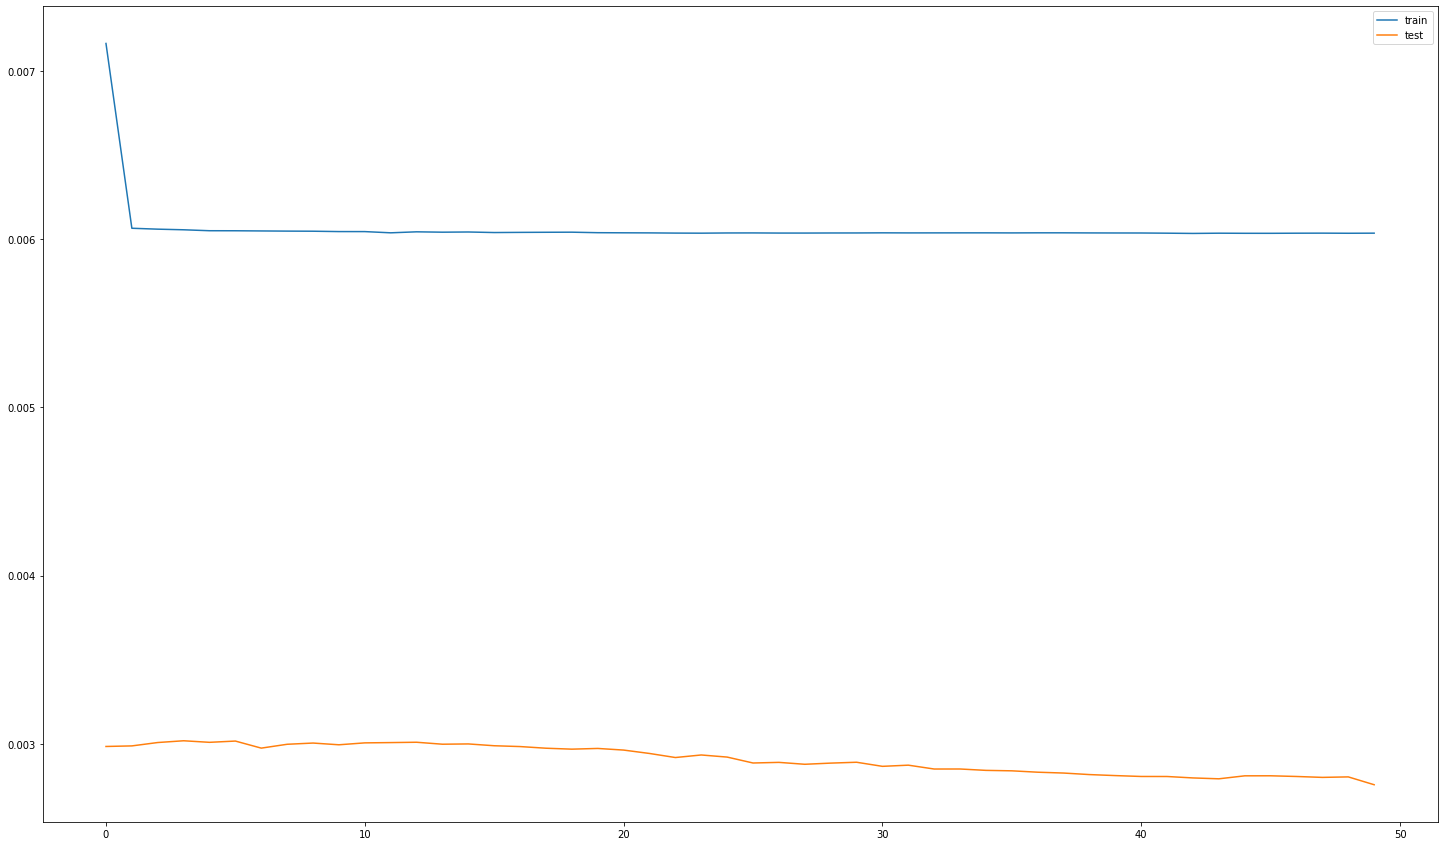

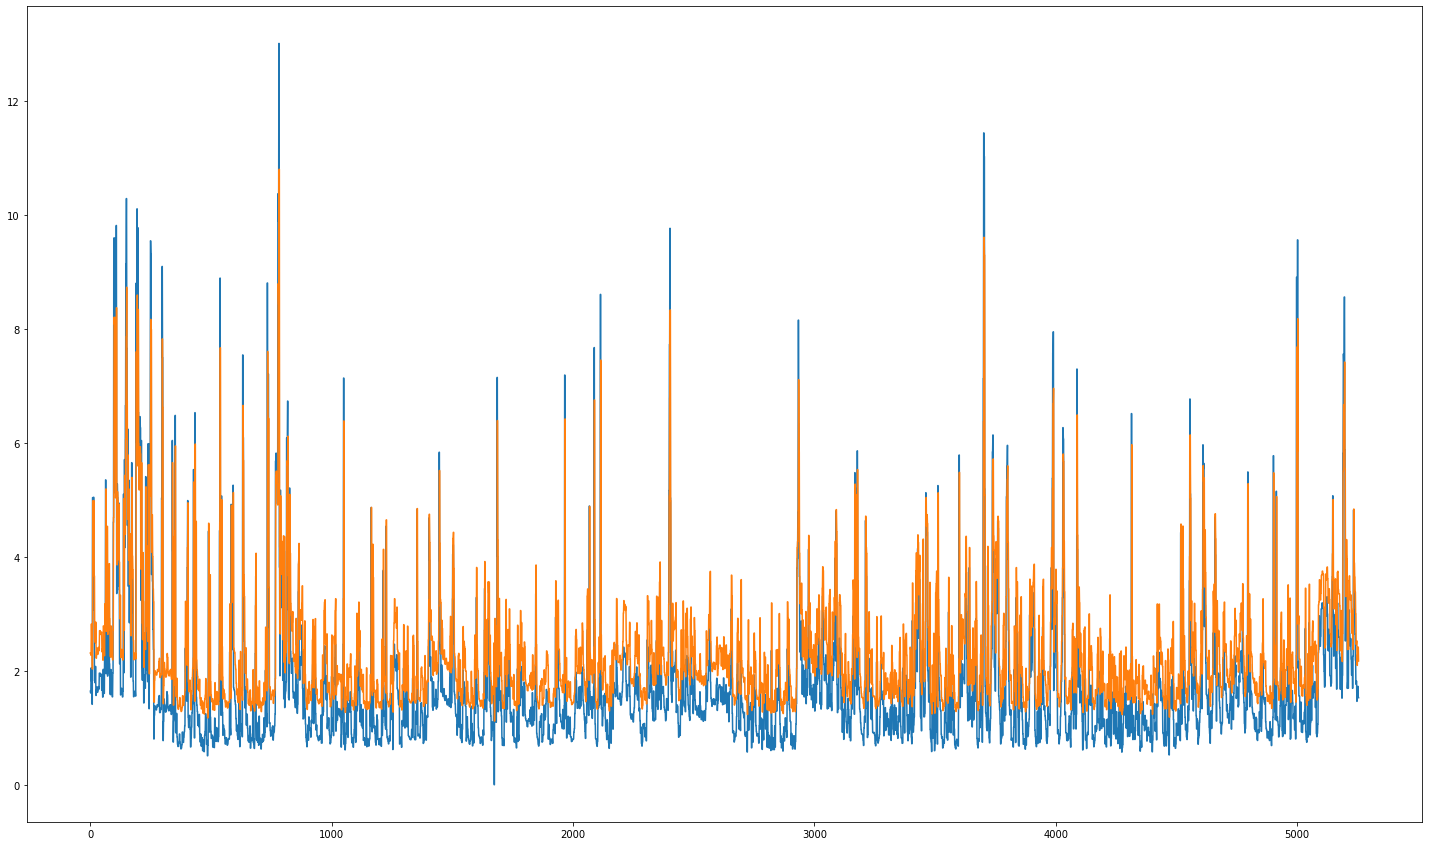

The RMSE in the train set is: 1.5269799587422417
The RMSE in the test set is: 0.9809948607219396


In [323]:
# pred_train ={}
# pred_test = {}

# rmse_train ={}
# rmse_test = {}

def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                            conv.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(conv.predict(X_test)).flatten()

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#plot the predictions
plt.plot(pred_test['true'][0:500])
plt.plot(pred_test['simple_lstm'][0:500])
plt.show()


rmse_test['single'] = rmse(pred_test['true'], pred_test['simple_lstm'])
rmse_train['single'] = rmse(pred_train['true'], pred_train['simple_lstm'])


print(f"The RMSE in the train set is: {rmse_train['single']}")
print(f"The RMSE in the test set is: {rmse_test['single']}")

### Stateful LSTM

In [160]:
batch_size=72
time_steps=1

In [139]:
singlemod = Sequential()
singlemod.add(LSTM(256, stateful=True, batch_input_shape= (batch_size, time_steps, 1)))
singlemod.add(Dense(1))

singlemod.compile(loss="mae", optimizer= 'adam', metrics=['mean_absolute_error','mean_absolute_percentage_error'])


In [140]:
# The modulo % is the remainder after devision
rest = len(y_train) % batch_size
rest

0

In [141]:

X_train, y_train = X_train[rest:,:], y_train[rest:,:]

In [142]:
for i in range(20):
    singlemod.fit(X_train, y_train, batch_size=batch_size, epochs=1,
          #validation_split=0.3, # We cannot afford validation data to be sampled automatically as this would break the data ordering 
          shuffle=False) # don't shuffle, we must keep the order of observations for the batches to match
    singlemod.reset_states()

156/156 [==============================] - 1s 8ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 4137.8901


In [143]:
X_test_extended = np.vstack([X_train, X_test])

In [144]:
# Drop early observations to accomodate batch size
X_test_extended = X_test_extended[(X_test_extended.shape[0] % batch_size):,:]

In [145]:
# Performance evaluation is ALMOST as usual 
pred_train["stateful"] = scaler.inverse_transform(
                              singlemod.predict(X_train,verbose=0, batch_size=batch_size)
).flatten()

# However, there is one important bit
singlemod.reset_states()

In [146]:
pred_test={}

In [147]:
pred_test_extended = singlemod.predict(X_test_extended, verbose=0, batch_size=batch_size)

pred_test["stateful"] = scaler.inverse_transform(
                              pred_test_extended[-len(y_test):]
).flatten()

# Collect the hidden states before resetting them
state_before_reset = [keras.backend.get_value(s) for s, _ in singlemod.state_updates]
state_before_reset
#stateful.reset_states()

/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_76205/4088356753.py:8: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  state_before_reset = [keras.backend.get_value(s) for s, _ in singlemod.state_updates]
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py:2721: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  if hasattr(layer, 'updates'):
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py:2722: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  state_updates += layer.updates


[]

In [148]:
pred_test_extended[-len(y_test):]

array([[0.07485981],
       [0.0496344 ],
       [0.05365141],
       ...,
       [0.10153005],
       [0.0964364 ],
       [0.10964121]], dtype=float32)

In [149]:
singlemod.fit(X_train, y_train, batch_size=batch_size, epochs=20)

Epoch 1/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 3875.7832
Epoch 2/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3477.1311
Epoch 3/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3846.0767
Epoch 4/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3426.2812
Epoch 5/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3725.6306
Epoch 6/20
156/156 [==============================] - 1s 7ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 3826.3826
Epoch 7/20
156/156 [==============================] - 1s 6ms/step - lo

In [150]:
len(pred_test['stateful'])

2812

In [151]:
pred_test['true']= np.array(y_test).reshape(y_test.shape[0])

In [152]:
pred_test['stateful'].shape
pred_test['true'].shape


(2812,)

<AxesSubplot:>

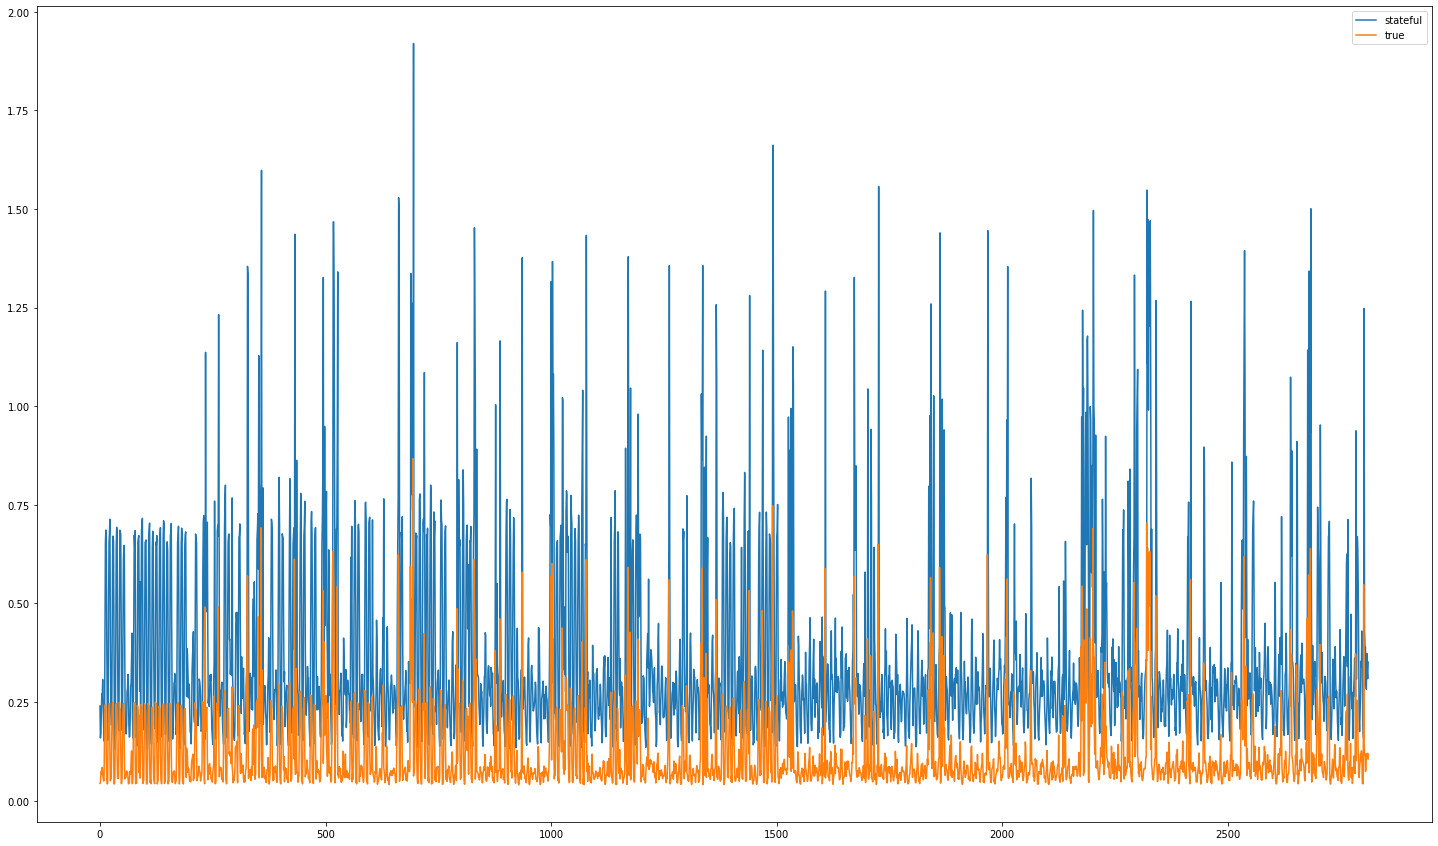

In [153]:
pd.DataFrame(pred_test).plot()

In [568]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Multivariate ConvLSTM

In [478]:
# multivariate cnn example

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = [],[]
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=1)
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 12267.2051
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 11593.1611
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 10933.1621
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 10286.8213
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 9654.5684
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 9042.6426
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 8446.6924
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 7865.7881
Epoch 9/100
1/1 [==============================] - 0s 5ms/step - loss: 7298.5947
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 6746.6753
Epoch 11/100
1/1 [==============================] - 0s 16ms/step - loss: 6219.0513
Epoch 12/100
1/1 [==============================] - 0s 9ms/step - loss: 5710.3052
Epoch 13/100
1/

In [479]:
X

array([[[10, 15],
        [20, 25],
        [30, 35]],

       [[20, 25],
        [30, 35],
        [40, 45]],

       [[30, 35],
        [40, 45],
        [50, 55]],

       [[40, 45],
        [50, 55],
        [60, 65]],

       [[50, 55],
        [60, 65],
        [70, 75]],

       [[60, 65],
        [70, 75],
        [80, 85]],

       [[70, 75],
        [80, 85],
        [90, 95]]])

In [476]:
def train_multi_convmodel(df, train_size = 0.8, neurons = 256, epochs=50, batch_size=24, plot=True):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean squared_error'''    
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    n_steps = X_train.shape[1]
    n_features= X_train.shape[2]

    # design network
  # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    if plot==True:

        # plot history
        plt.plot(history2.history['loss'], label='train')
        #plt.plot(history2.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    else:
        pass

    #Predict model
    yhat= model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    inv_yhat = np.concatenate((X_test, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat=inv_yhat[:,-1]
    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    inv_y= np.concatenate((X_test, y_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)

    inv_y = inv_y[:,-1]

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
   
    multi_pred_train={}
    multi_pred_test={}

    multi_pred_test['true'] = inv_y
    multi_pred_test['multi'] = inv_yhat

    multi_rmse_test={}
    multi_rmse_test["multi"]  = rmse(multi_pred_test["true"],  multi_pred_test["multi"])

    print(multi_rmse_test)

    multi_pred_test = pd.DataFrame(multi_pred_test)

    if plot==True:
        multi_pred_test.plot(lw=1.5)
    else:
        pass

In [475]:
multi_pred_train ={}
multi_pred_test = {}

multi_rmse_train = {}
multi_rmse_test = {}


In [477]:
train_multi_convmodel(home_a, neurons=512, epochs=10, batch_size=168)

(11248, 1, 5) (11248,) (2813, 1, 5) (2813,)


ValueError: Exception encountered when calling layer "conv1d_45" (type Conv1D).

Negative dimension size caused by subtracting 2 from 1 for '{{node conv1d_45/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_45/Conv1D/ExpandDims, conv1d_45/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,5], [1,2,5,64].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 5), dtype=float32)

In [481]:

    #Drop nan values
    home_a= home_a.dropna()
    # train, test split
    # split into train and test sets
    values = home_a.values
    train, test = train_test_split(values, train_size=0.8, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    n_steps = X_train.shape[1]
    n_features= X_train.shape[2]


(11248, 1, 5) (11248,) (2813, 1, 5) (2813,)


In [484]:

    # design network
  # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=n_features, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=n_features))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')


   

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_49. Consider increasing the input size. Received input shape [None, 1, 5] which would produce output shape with a zero or negative value in a dimension.

In [ ]:
 # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    

In [ ]:
if plot==True:

        # plot history
        plt.plot(history2.history['loss'], label='train')
        #plt.plot(history2.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    else:
        pass

    #Predict model
    yhat= model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    inv_yhat = np.concatenate((X_test, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat=inv_yhat[:,-1]
    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    inv_y= np.concatenate((X_test, y_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)

    inv_y = inv_y[:,-1]

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
   
    multi_pred_train={}
    multi_pred_test={}

    multi_pred_test['true'] = inv_y
    multi_pred_test['multi'] = inv_yhat

    multi_rmse_test={}
    multi_rmse_test["multi"]  = rmse(multi_pred_test["true"],  multi_pred_test["multi"])

    print(multi_rmse_test)

    multi_pred_test = pd.DataFrame(multi_pred_test)

    if plot==True:
        multi_pred_test.plot(lw=1.5)
    else:
        pass

# Federated approach

In [236]:
import tensorflow as tf

In [237]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [238]:
class SimpleLSTM:
    @staticmethod
    def build(neurons, timesteps =1, n_features=1):
        model = Sequential()
        model.add(LSTM(neurons, input_shape =(timesteps,n_features)))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])
        
        
        return model

In [239]:
def weight_scalling_factor(clients_trn_data, client_name):
    #client_names = list(homes.columns())
    #get the bs
    #bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clients
    global_count = sum([len(clients_trn_data[client_name].dropna()) for client_name in client_names])
    # get the total number of data points held by a client
    local_count = len(clients_trn_data[client_name].dropna())
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error
    
def test_model(X_test, Y_test,  model, comm_round, home):
    preds = model.predict(X_test)
    loss = rmse(Y_test, preds)
    print('comm_round: {} | loss_in_{}: {}'.format(comm_round,home,loss))
    return loss, preds

In [240]:
def prepare_task(home: pd.Series, train_size= 0.9, timesteps= 1, epochs=50, batch_size= 64):
    """function that wraps all the processes of data preparation and model configuration"""
     #Drop nan values
    home= home.dropna()

    # train, test split
    # split into train and test sets
    values = home.values
    values= values.reshape(len(values),1)
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    # The LSTM input layer must be 3D
    # Create the dataset with rolling window for the training set and test set
    X_train, y_train  = create_dataset(train, timesteps)  # lookback
    X_test, y_test    = create_dataset(test, timesteps)
    #print(X_train.shape)

    return X_train, y_train, X_test, y_test


In [241]:
comms_round = 10
    
#create optimizer
lr = 0.01 
loss='mean_squared_error'
metrics = ['mse']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 



In [113]:
client_names = homes.columns
print(client_names)

Index(['total_a', 'total_b', 'total_c', 'total_d', 'total_f', 'total_g',
       'total_h'],
      dtype='object')


In [242]:
#initialize global model
smlp_global = SimpleLSTM()
global_model = smlp_global.build(256, 1, 1)
        


In [81]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()


    
    #loop through each client and create new local model
    for home in homes:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(256)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
       
 #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        X_train, y_train, X_test, y_test ,scaler= prepare_task(homes[home])

        local_model.fit(X_train, y_train, epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(homes, home)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss = test_model(X_test, y_test, global_model, comm_round, home)
        
        #clear session to free memory after each communication round
        K.clear_session()

        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    #global_loss = test_model(X_test, y_test, global_model, comm_round)
        



NameError: name 'client_names' is not defined

In [243]:

pred_train={}
pred_test= {}

rmse_train={}
rmse_test={}

In [246]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for home in homes:
        smlp_local = SimpleLSTM()
        local_model = smlp_local.build(256)
        local_model.compile(loss=loss, 
                        optimizer="adam", #Trying out adam
                        metrics=metrics)
        
        
    #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        #scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, y_train, X_test, y_test= prepare_task(homes[home])


        local_model.fit(X_train, y_train, epochs=10, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(homes, home)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        local_loss = test_model(X_test, y_test, global_model, comm_round, home)


        pred_train[f"true_{home}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
        pred_test[f"true_{home}"]  = scaler.inverse_transform(y_test).flatten() 

        pred_train[f"simple_lstm_{home}"] = scaler.inverse_transform(
                                    local_model.predict(X_train)).flatten()

        pred_test[f"simple_lstm_{home}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

        rmse_test[f'single_{home}'] = rmse(pred_test[f'true_{home}'], pred_test[f'simple_lstm_{home}'])
        rmse_train[f'single_{home}'] = rmse(pred_train[f'true_{home}'], pred_train[f'simple_lstm_{home}'])

        # #plot the predictions
        # plt.plot(pred_test[f'true_{home}'])
        # plt.plot(pred_test[f'simple_lstm_{home}'])
        # plt.show()

        K.clear_session()
    
            
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
  

comm_round: 0 | loss_in_total_a: 0.07984852650074632
comm_round: 0 | loss_in_total_b: 0.03699703776740643
comm_round: 0 | loss_in_total_c: 0.07190049604417798
comm_round: 0 | loss_in_total_d: 0.084408200383261
comm_round: 0 | loss_in_total_f: 0.03864667154068289
comm_round: 0 | loss_in_total_g: 0.09027215188333626
comm_round: 0 | loss_in_total_h: 0.10664358243232376
comm_round: 1 | loss_in_total_a: 0.0792772905160979
comm_round: 1 | loss_in_total_b: 0.036015848752697435
comm_round: 1 | loss_in_total_c: 0.07305218150539998
comm_round: 1 | loss_in_total_d: 0.08601476818715008
comm_round: 1 | loss_in_total_f: 0.03672834677966245
comm_round: 1 | loss_in_total_g: 0.09006666376691323
comm_round: 1 | loss_in_total_h: 0.1055695459724064
comm_round: 2 | loss_in_total_a: 0.07862668975933039
comm_round: 2 | loss_in_total_b: 0.03601985291810937
comm_round: 2 | loss_in_total_c: 0.07457317551396697
comm_round: 2 | loss_in_total_d: 0.08820321165754555
comm_round: 2 | loss_in_total_f: 0.03620488215470

In [249]:
pred_test.keys()

dict_keys(['true_total_a', 'simple_lstm_total_a', 'true_total_b', 'simple_lstm_total_b', 'true_total_c', 'simple_lstm_total_c', 'true_total_d', 'simple_lstm_total_d', 'true_total_f', 'simple_lstm_total_f', 'true_total_g', 'simple_lstm_total_g', 'true_total_h', 'simple_lstm_total_h'])

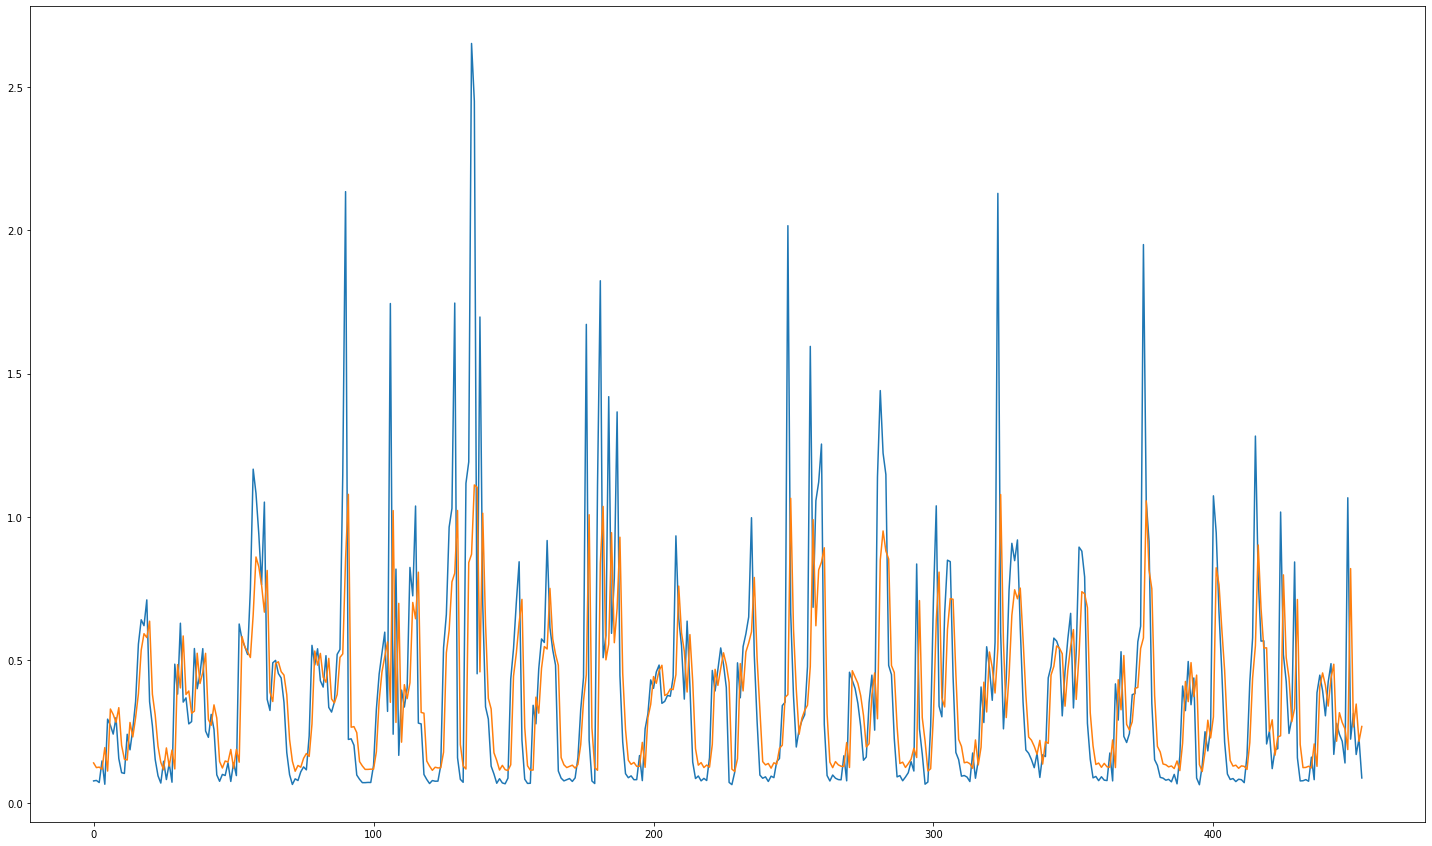

In [253]:
plt.plot(pred_test['true_total_h'])
plt.plot(pred_test['simple_lstm_total_h'])

In [226]:
smlp_local = SimpleLSTM()
local_model = smlp_local.build(256)
local_model.compile(loss=loss, 
                optimizer="adam", #Switch to ADAM to test
                metrics=metrics)


#set local model weight to the weight of the global model
#local_model.set_weights(global_weights)



In [227]:
#fit local model with client's data
#scaler = MinMaxScaler(feature_range=(0, 1))
X_train, y_train, X_test, y_test= prepare_task(homes['total_a'])


local_model.fit(X_train, y_train, epochs=1, verbose=1)


496/496 [==============================] - 5s 5ms/step - loss: 0.0068 - mse: 0.0068


In [228]:
preds = local_model.predict(X_test)

In [229]:

#scale the model weights and add to list
scaling_factor = weight_scalling_factor(homes, 'total_a')
scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
scaled_local_weight_list.append(scaled_weights)



In [212]:
local_loss, preds = test_model(X_test, y_test, global_model, comm_round, home)



comm_round: 9 | loss_in_total_h: 0.14431435661875994


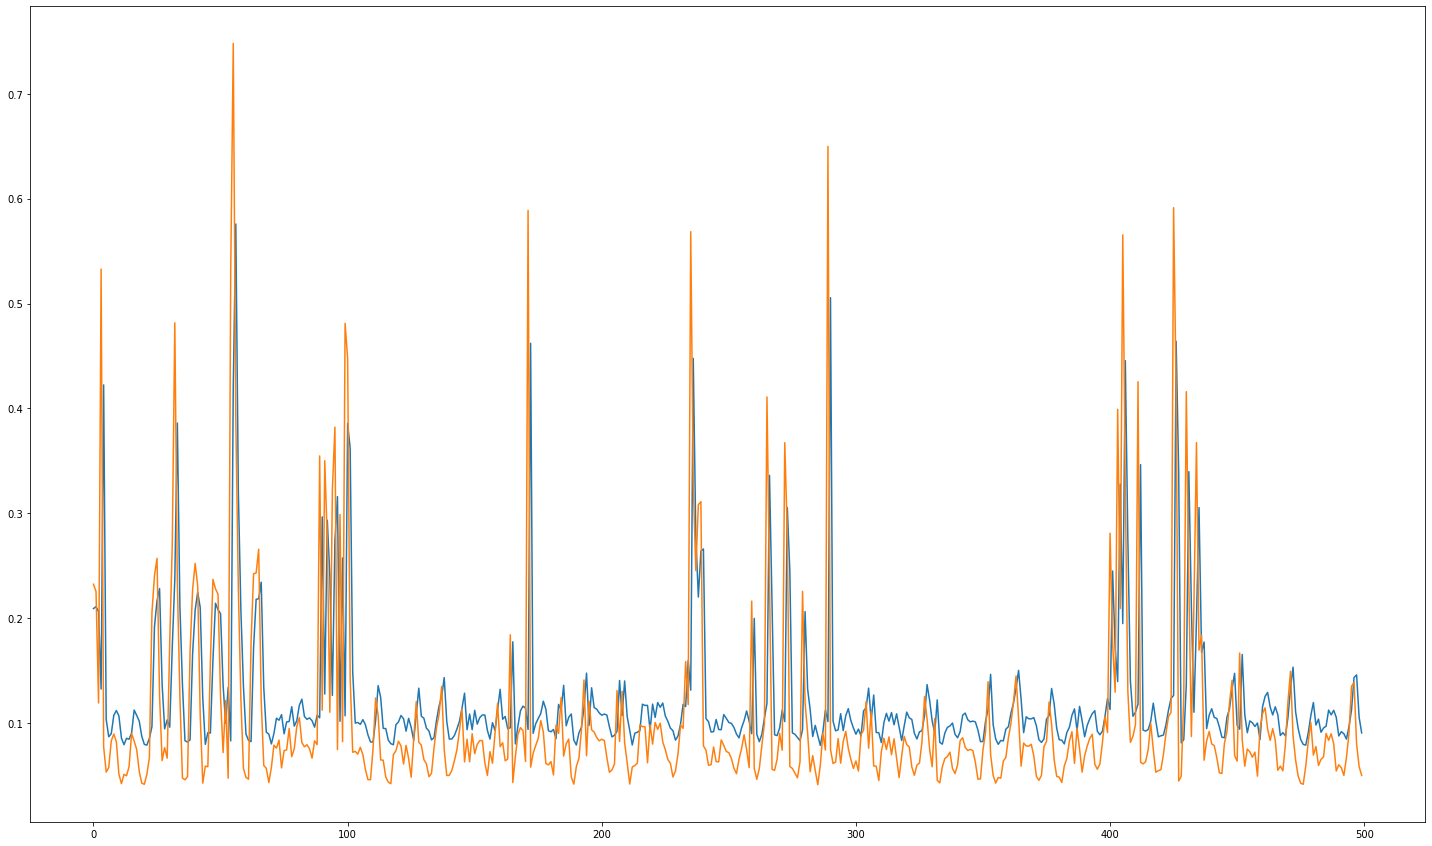

In [230]:
preds1= preds.flatten()
plt.plot(preds1[:500])
plt.plot(y_test.flatten()[:500])

In [ ]:

#pred_train[f"true_{home}"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test[f"true_total_a"]  = scaler.inverse_transform(y_test).flatten() 

pred_train[f"simple_lstm_{home}"] = scaler.inverse_transform(
                            local_model.predict(X_train)).flatten()

pred_test[f"simple_lstm_{home}"] = scaler.inverse_transform(local_model.predict(X_test)).flatten()

rmse_test[f'single_{home}'] = rmse(pred_test[f'true_{home}'], pred_test[f'simple_lstm_{home}'])
rmse_train[f'single_{home}'] = rmse(pred_train[f'true_{home}'], pred_train[f'simple_lstm_{home}'])

# Normal training

In [366]:
pred_train = {}
pred_test = {}

rmse_train ={}
rmse_test ={}

(15851, 1, 1)
Epoch 1/10
248/248 - 3s - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0062 - val_mse: 0.0062 - 3s/epoch - 14ms/step
Epoch 2/10
248/248 - 1s - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0061 - val_mse: 0.0061 - 692ms/epoch - 3ms/step
Epoch 3/10
248/248 - 1s - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0061 - val_mse: 0.0061 - 700ms/epoch - 3ms/step
Epoch 4/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 696ms/epoch - 3ms/step
Epoch 5/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 674ms/epoch - 3ms/step
Epoch 6/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 698ms/epoch - 3ms/step
Epoch 7/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 699ms/epoch - 3ms/step
Epoch 8/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0061 - val_mse: 0.0061 - 1s/epoch - 4ms/step
Epoch 9/10
248/248 - 1s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0060

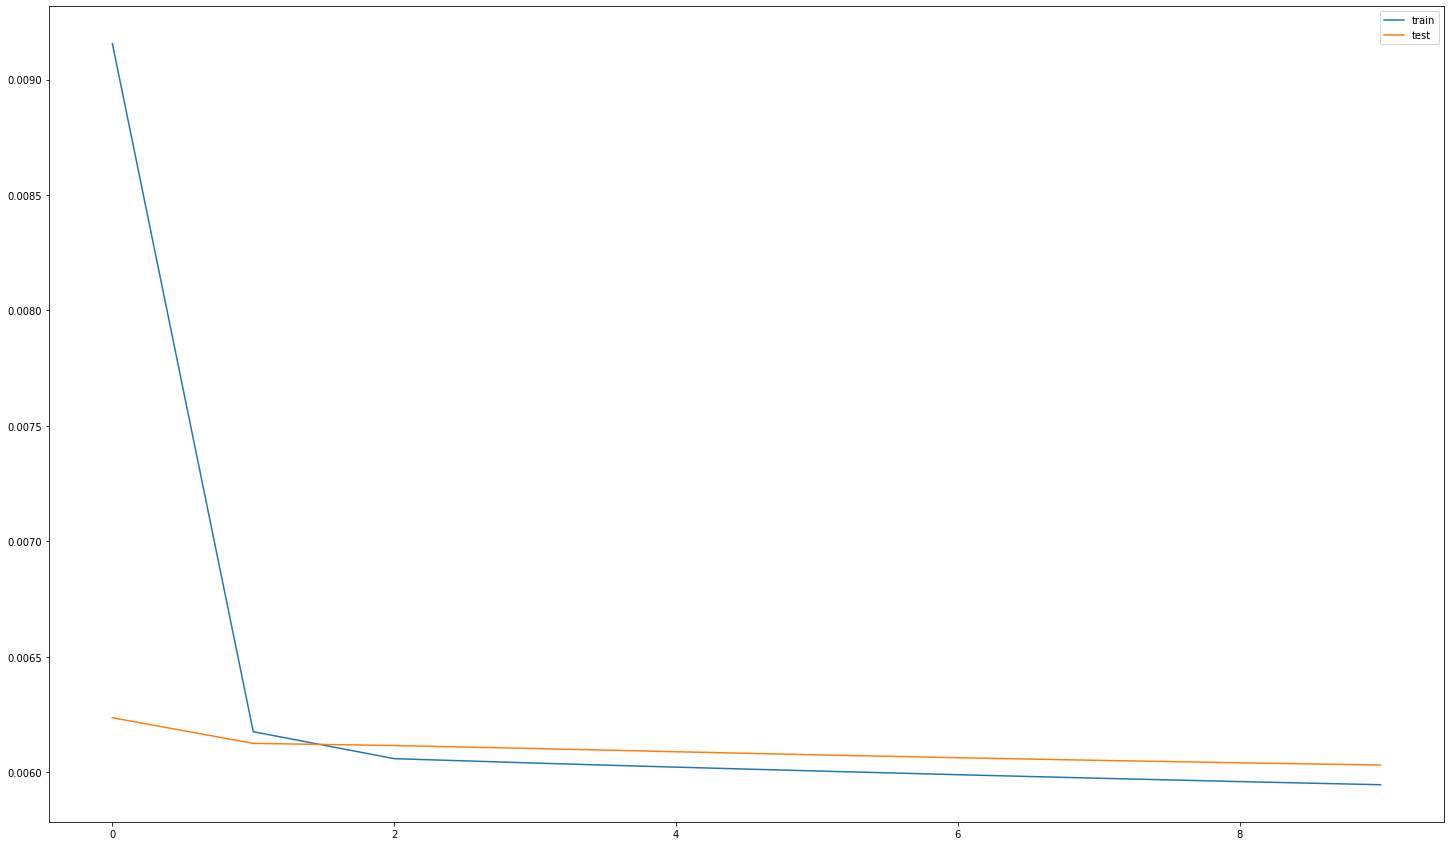

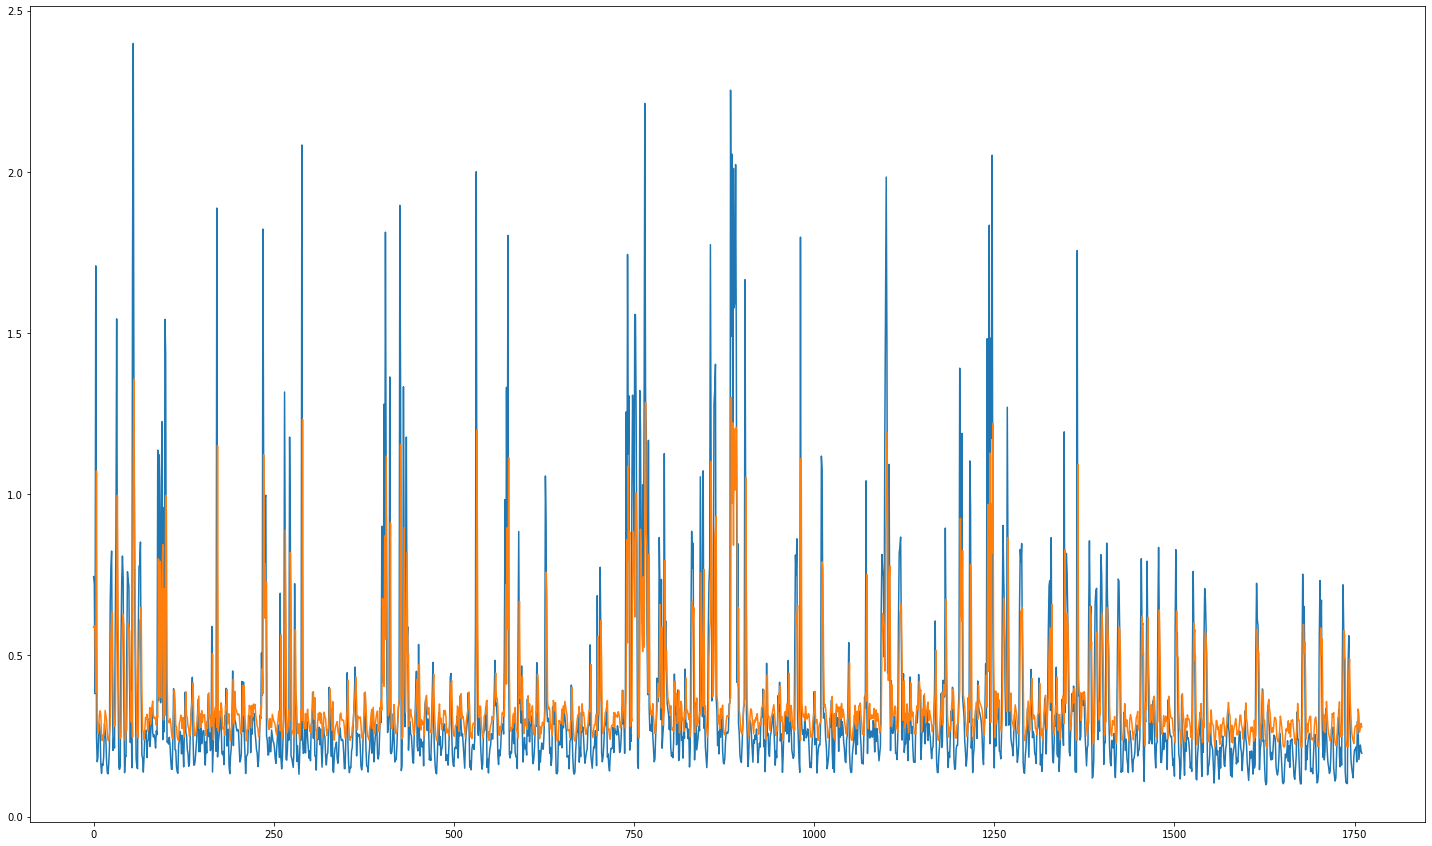

The RMSE in the train set is: 0.25198392546392745
The RMSE in the test set is: 0.24900272961725892
(23651, 1, 1)
Epoch 1/10
370/370 - 4s - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0013 - val_mse: 0.0013 - 4s/epoch - 10ms/step
Epoch 2/10
370/370 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 3ms/step
Epoch 3/10
370/370 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 3ms/step
Epoch 4/10
370/370 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 3ms/step
Epoch 5/10
370/370 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 3ms/step
Epoch 6/10
370/370 - 1s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 3ms/step
Epoch 7/10
370/370 - 1s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 3ms/step
Epoch 8/10
370/370 - 1s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch -

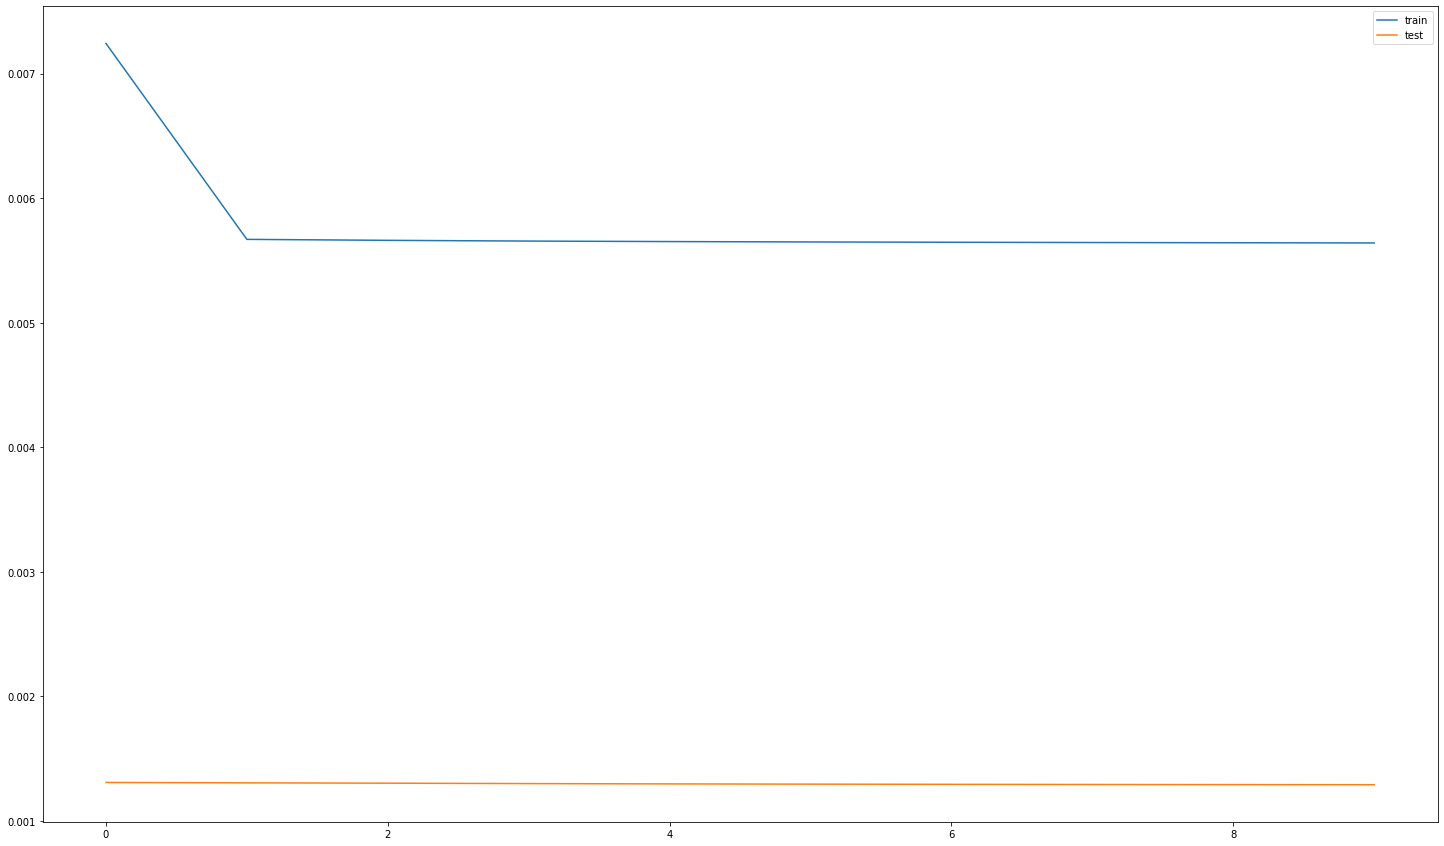

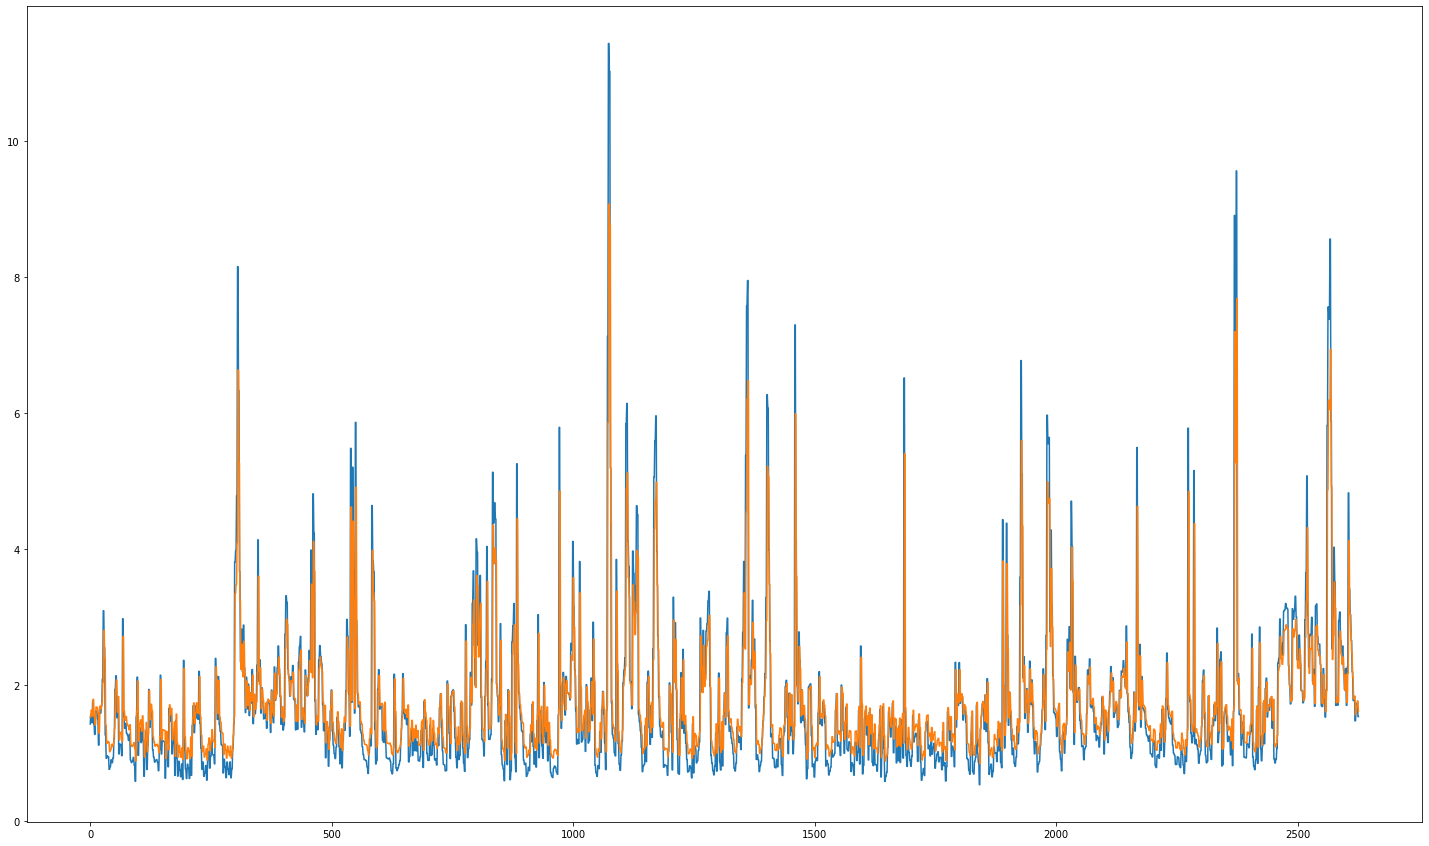

The RMSE in the train set is: 1.4234780325964709
The RMSE in the test set is: 0.6708378948110469
(31210, 1, 1)
Epoch 1/10
488/488 - 4s - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0054 - val_mse: 0.0054 - 4s/epoch - 7ms/step
Epoch 2/10
488/488 - 1s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0051 - val_mse: 0.0051 - 1s/epoch - 3ms/step
Epoch 3/10
488/488 - 2s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0051 - val_mse: 0.0051 - 2s/epoch - 3ms/step
Epoch 4/10
488/488 - 2s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0051 - val_mse: 0.0051 - 2s/epoch - 4ms/step
Epoch 5/10
488/488 - 1s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 1s/epoch - 3ms/step
Epoch 6/10
488/488 - 2s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 2s/epoch - 4ms/step
Epoch 7/10
488/488 - 1s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 1s/epoch - 3ms/step
Epoch 8/10
488/488 - 1s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0052 - val_mse: 0.0052 - 1s/epoch - 3m

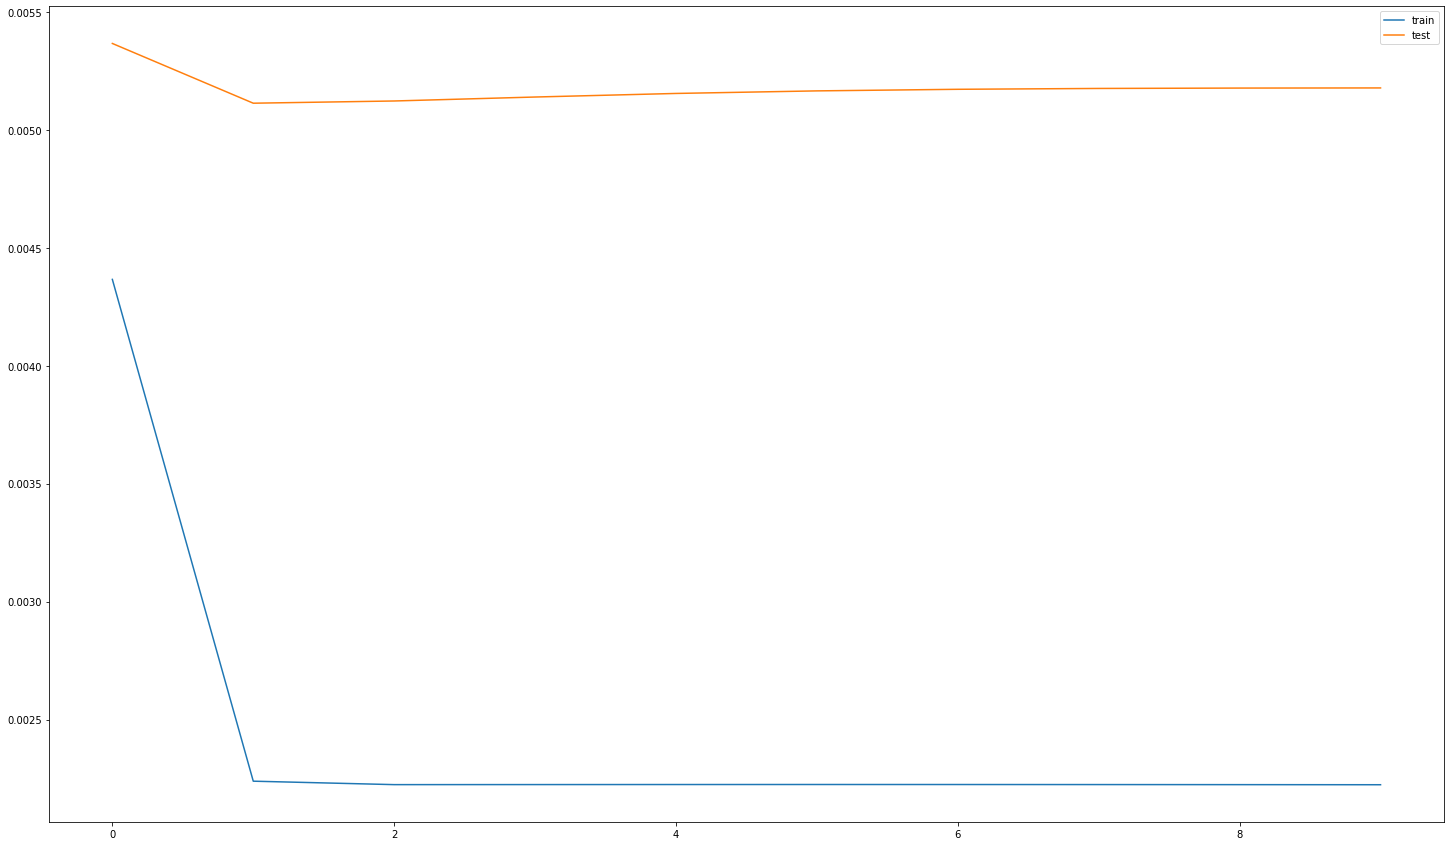

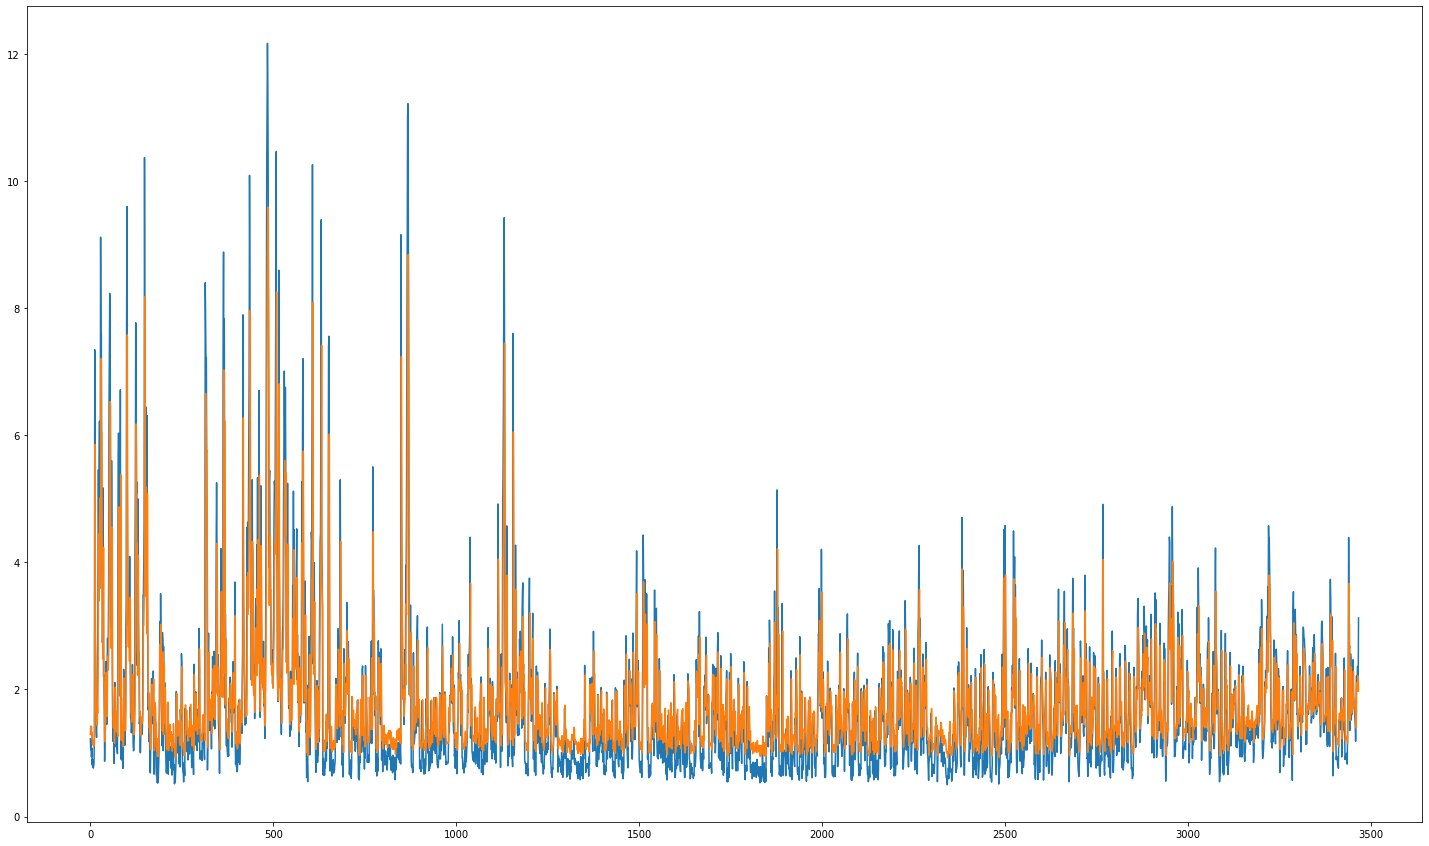

The RMSE in the train set is: 0.549947505333821
The RMSE in the test set is: 0.8083240626243448
(13000, 1, 1)
Epoch 1/10
204/204 - 5s - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0069 - val_mse: 0.0069 - 5s/epoch - 23ms/step
Epoch 2/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0069 - val_mse: 0.0069 - 626ms/epoch - 3ms/step
Epoch 3/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0069 - val_mse: 0.0069 - 643ms/epoch - 3ms/step
Epoch 4/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 625ms/epoch - 3ms/step
Epoch 5/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 825ms/epoch - 4ms/step
Epoch 6/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 669ms/epoch - 3ms/step
Epoch 7/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.0070 - 636ms/epoch - 3ms/step
Epoch 8/10
204/204 - 1s - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0070 - val_mse: 0.00

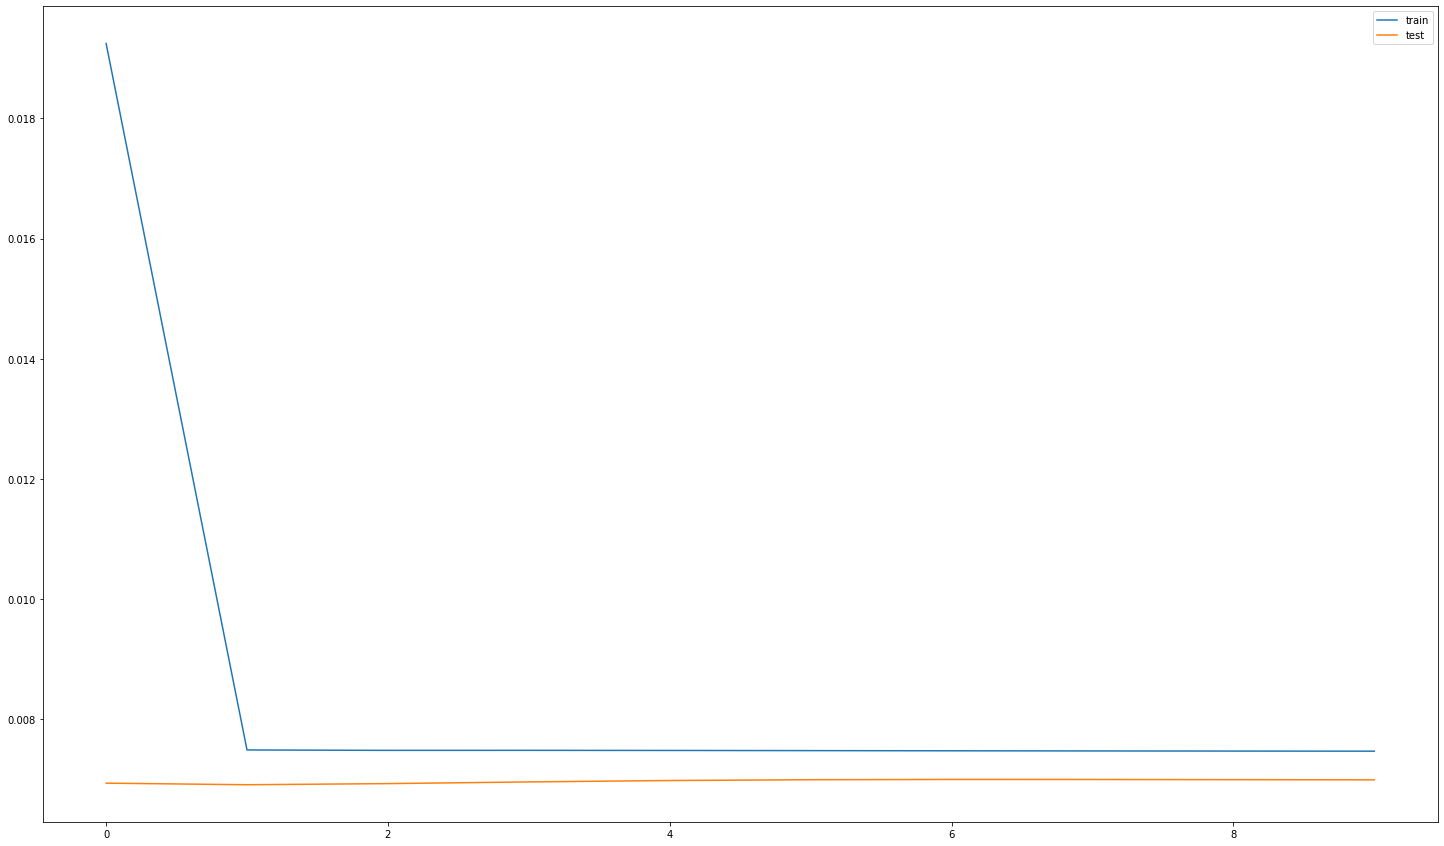

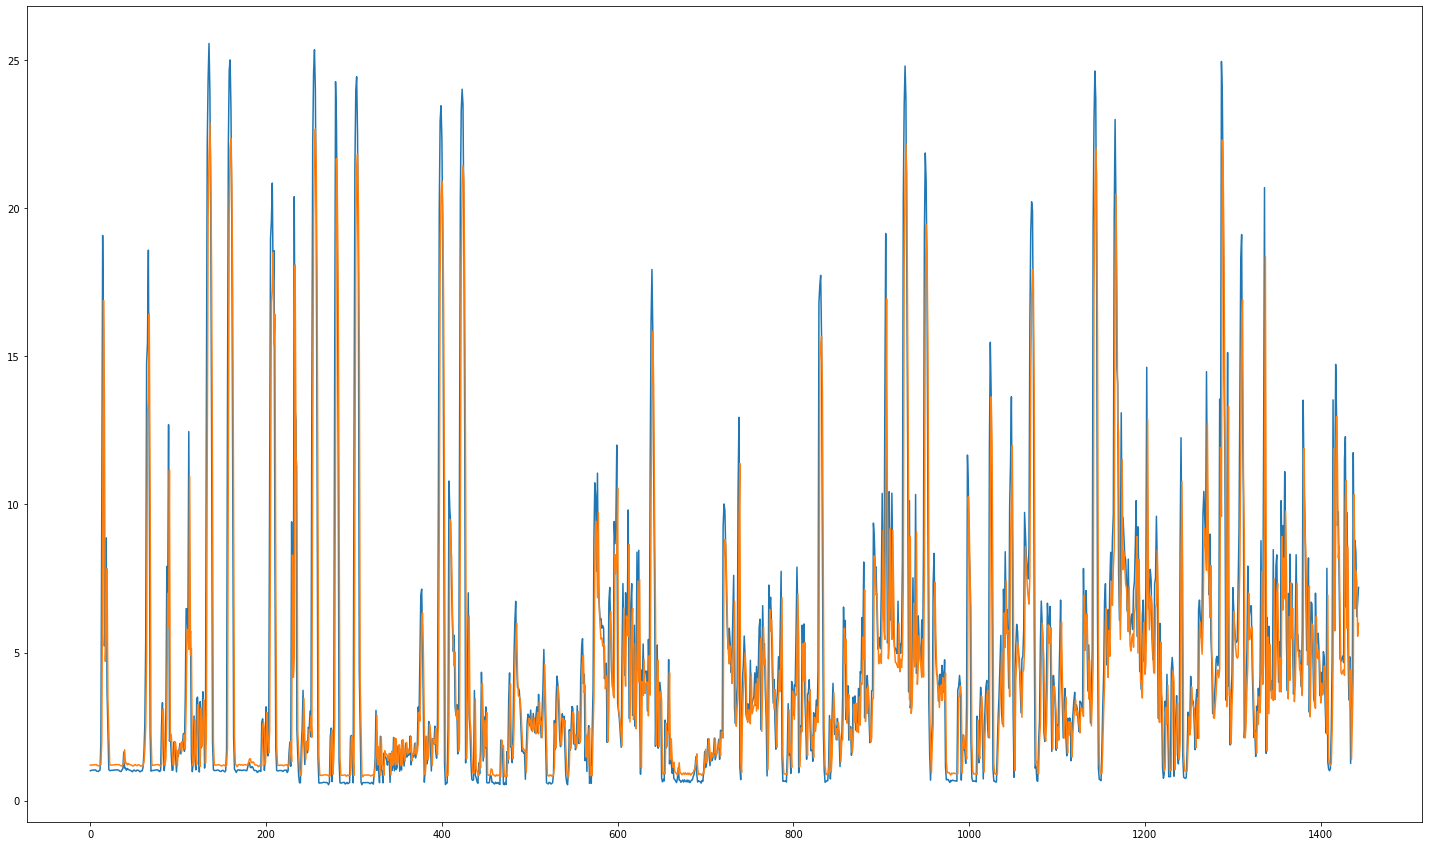

The RMSE in the train set is: 2.8672947099946584
The RMSE in the test set is: 2.740319521861948
(31556, 1, 1)
Epoch 1/10
494/494 - 5s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0013 - val_mse: 0.0013 - 5s/epoch - 9ms/step
Epoch 2/10
494/494 - 2s - loss: 8.6042e-04 - mse: 8.6042e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 3ms/step
Epoch 3/10
494/494 - 2s - loss: 8.5974e-04 - mse: 8.5974e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 4ms/step
Epoch 4/10
494/494 - 2s - loss: 8.5835e-04 - mse: 8.5835e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 3ms/step
Epoch 5/10
494/494 - 1s - loss: 8.5664e-04 - mse: 8.5664e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 1s/epoch - 3ms/step
Epoch 6/10
494/494 - 2s - loss: 8.5484e-04 - mse: 8.5484e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 3ms/step
Epoch 7/10
494/494 - 2s - loss: 8.5304e-04 - mse: 8.5304e-04 - val_loss: 0.0013 - val_mse: 0.0013 - 2s/epoch - 3ms/step
Epoch 8/10
494/494 - 2s - loss: 8.5128e-04 - mse: 8.5128e-

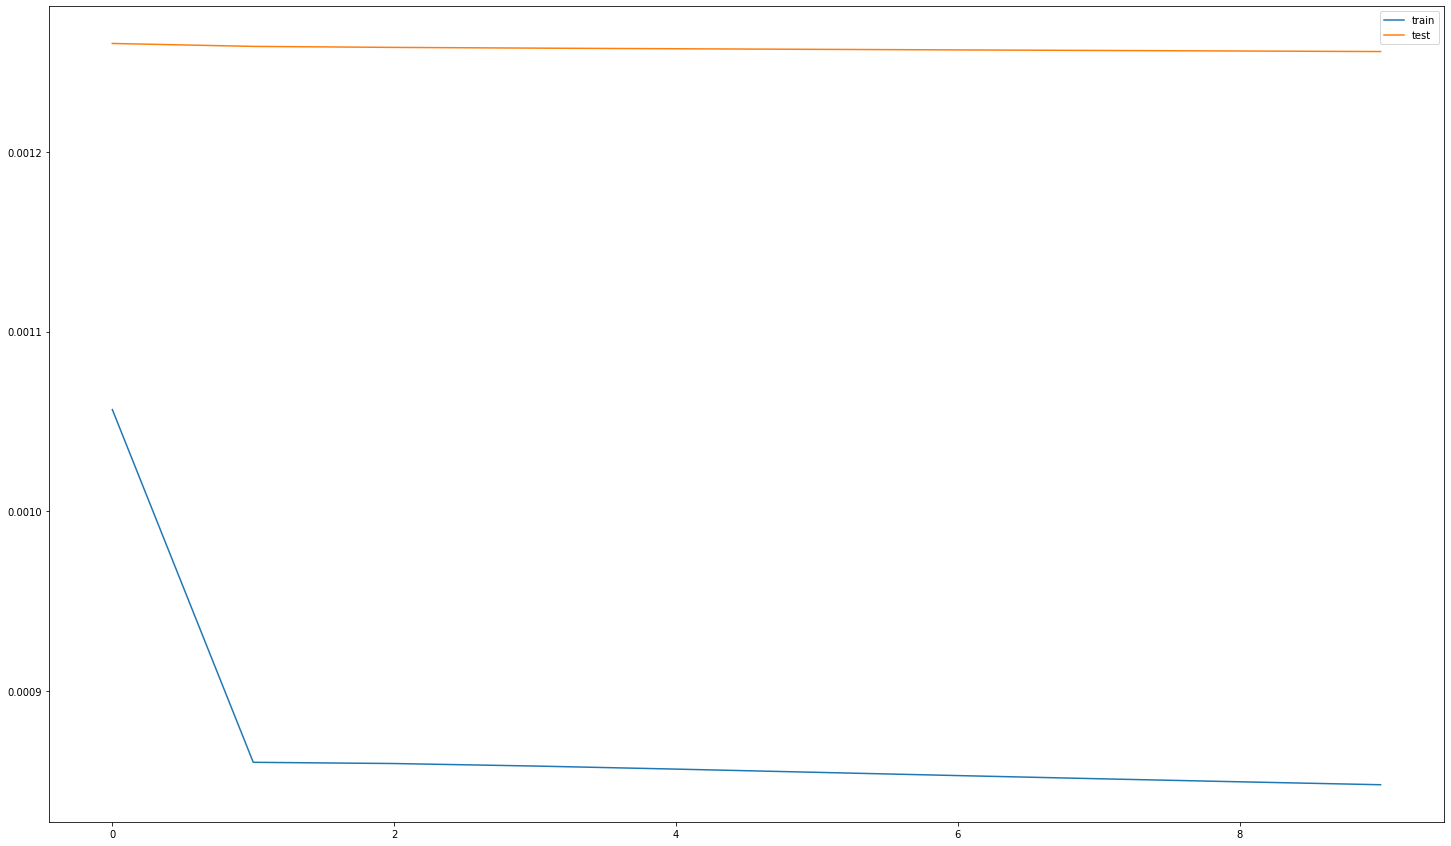

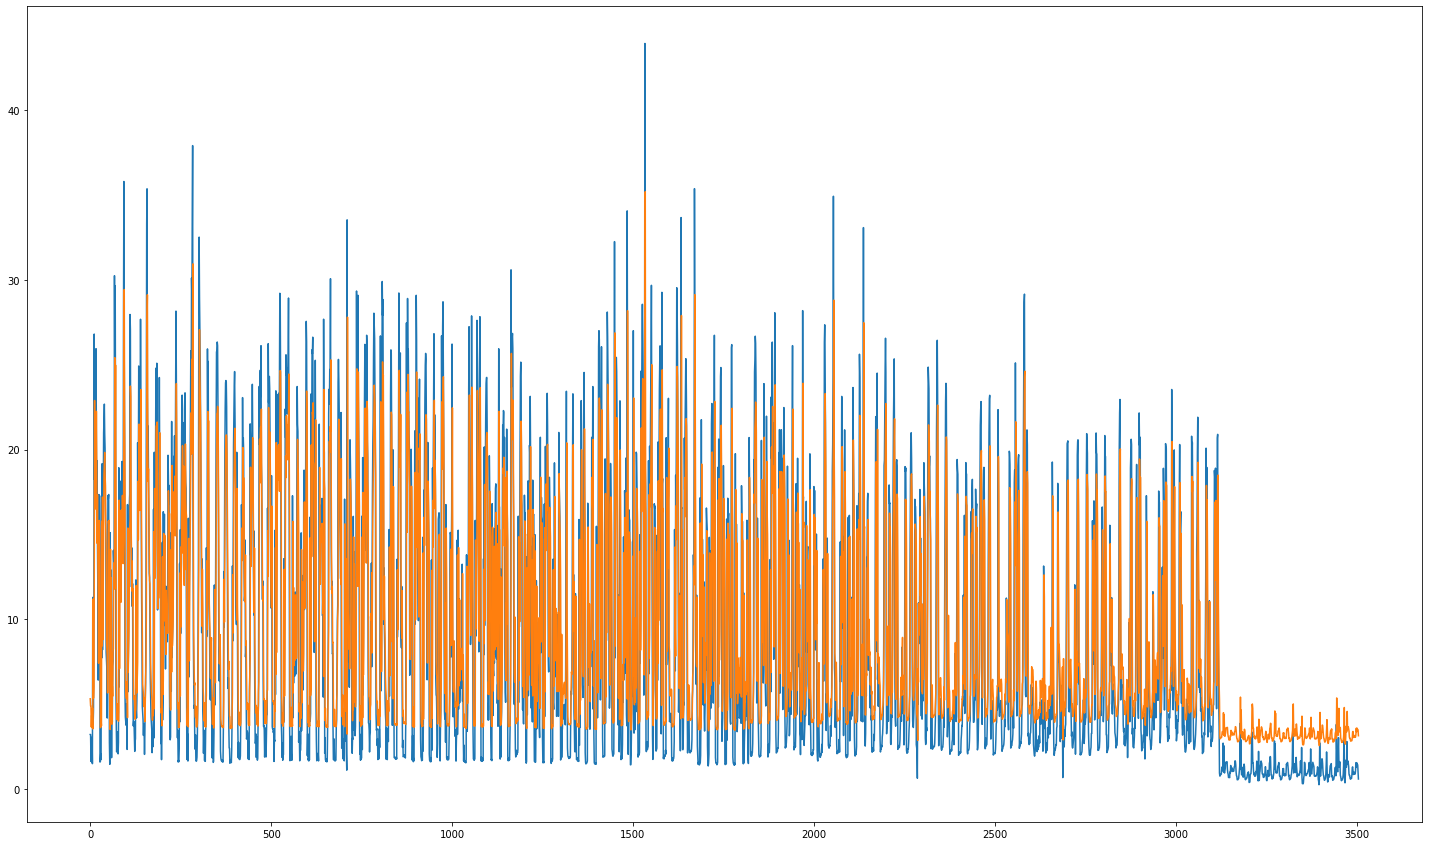

The RMSE in the train set is: 4.306161535604909
The RMSE in the test set is: 5.139614918251073
(13360, 1, 1)
Epoch 1/10
209/209 - 3s - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0183 - val_mse: 0.0183 - 3s/epoch - 12ms/step
Epoch 2/10
209/209 - 1s - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0139 - val_mse: 0.0139 - 633ms/epoch - 3ms/step
Epoch 3/10
209/209 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0114 - val_mse: 0.0114 - 578ms/epoch - 3ms/step
Epoch 4/10
209/209 - 1s - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0103 - val_mse: 0.0103 - 734ms/epoch - 4ms/step
Epoch 5/10
209/209 - 1s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0099 - val_mse: 0.0099 - 585ms/epoch - 3ms/step
Epoch 6/10
209/209 - 1s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0097 - val_mse: 0.0097 - 591ms/epoch - 3ms/step
Epoch 7/10
209/209 - 1s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0097 - val_mse: 0.0097 - 615ms/epoch - 3ms/step
Epoch 8/10
209/209 - 1s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0097 - val_mse: 0.009

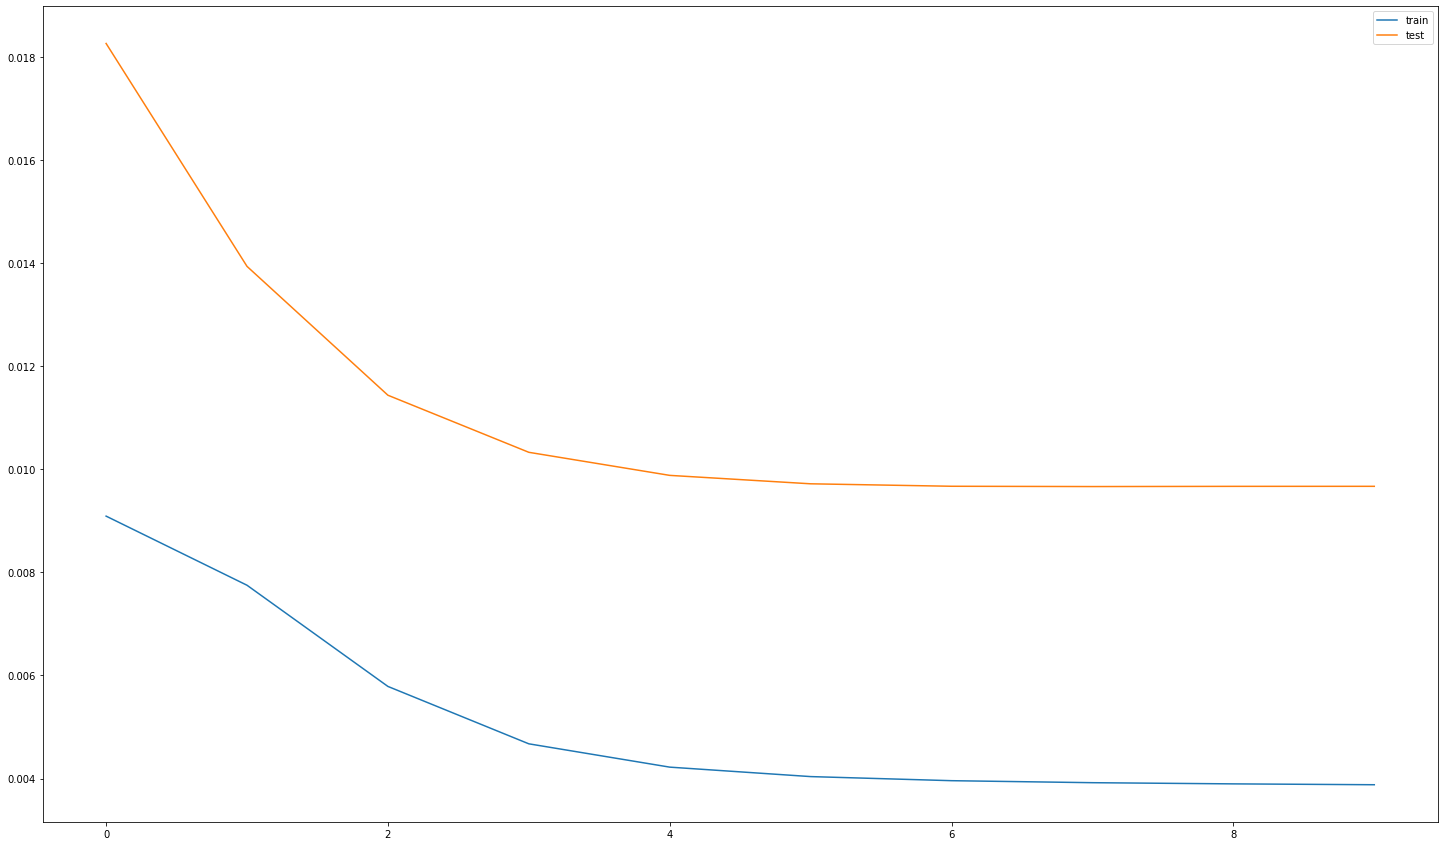

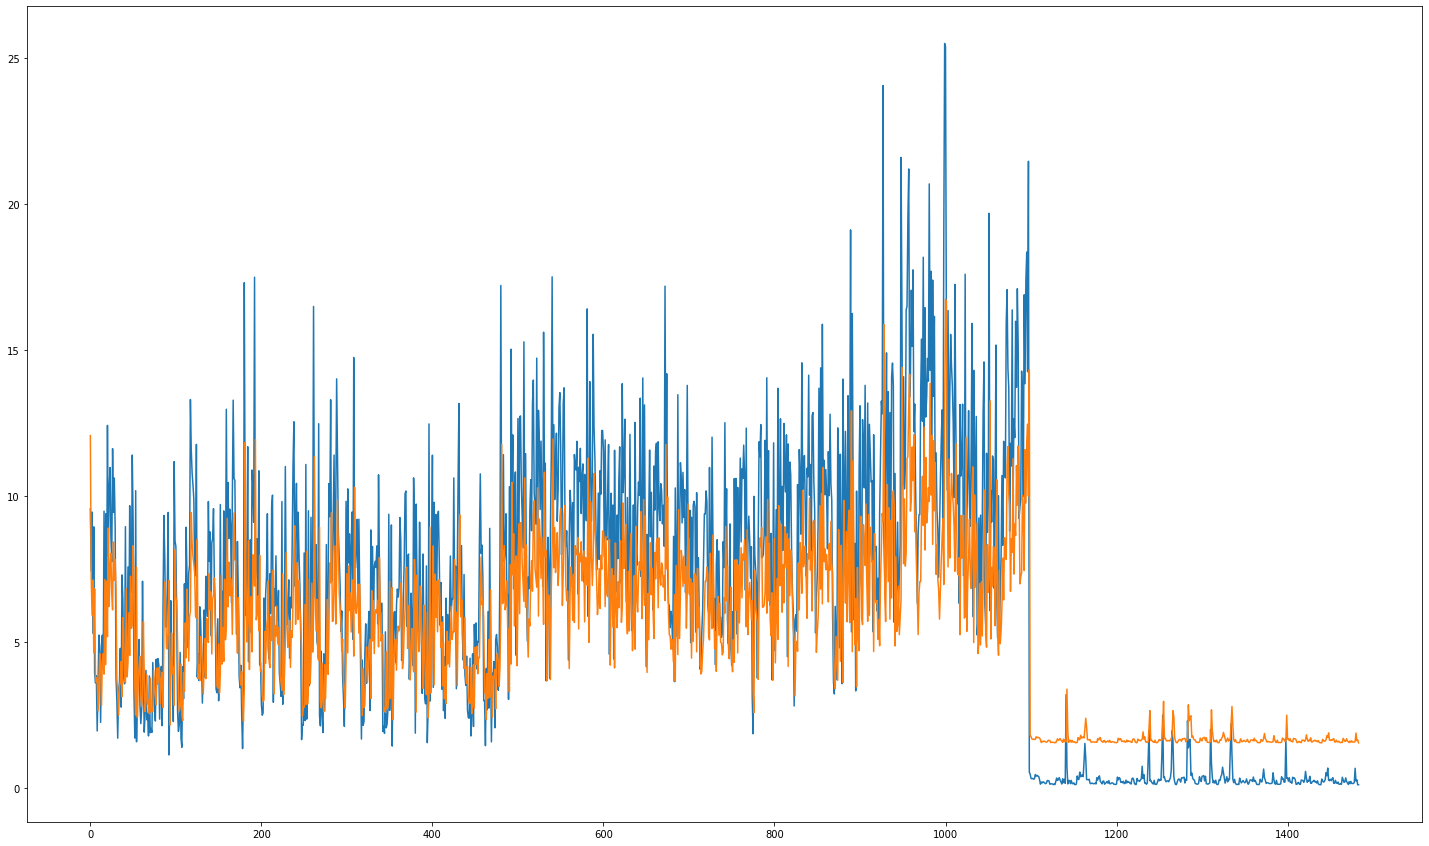

The RMSE in the train set is: 2.544037302084774
The RMSE in the test set is: 3.3394041076093184
(4089, 1, 1)
Epoch 1/10
64/64 - 2s - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0126 - val_mse: 0.0126 - 2s/epoch - 34ms/step
Epoch 2/10
64/64 - 0s - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0117 - val_mse: 0.0117 - 242ms/epoch - 4ms/step
Epoch 3/10
64/64 - 0s - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0113 - val_mse: 0.0113 - 231ms/epoch - 4ms/step
Epoch 4/10
64/64 - 0s - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0111 - val_mse: 0.0111 - 225ms/epoch - 4ms/step
Epoch 5/10
64/64 - 0s - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0111 - val_mse: 0.0111 - 251ms/epoch - 4ms/step
Epoch 6/10
64/64 - 0s - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0110 - val_mse: 0.0110 - 231ms/epoch - 4ms/step
Epoch 7/10
64/64 - 0s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0110 - val_mse: 0.0110 - 233ms/epoch - 4ms/step
Epoch 8/10
64/64 - 0s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0110 - val_mse: 0.0110 - 225ms/epoch 

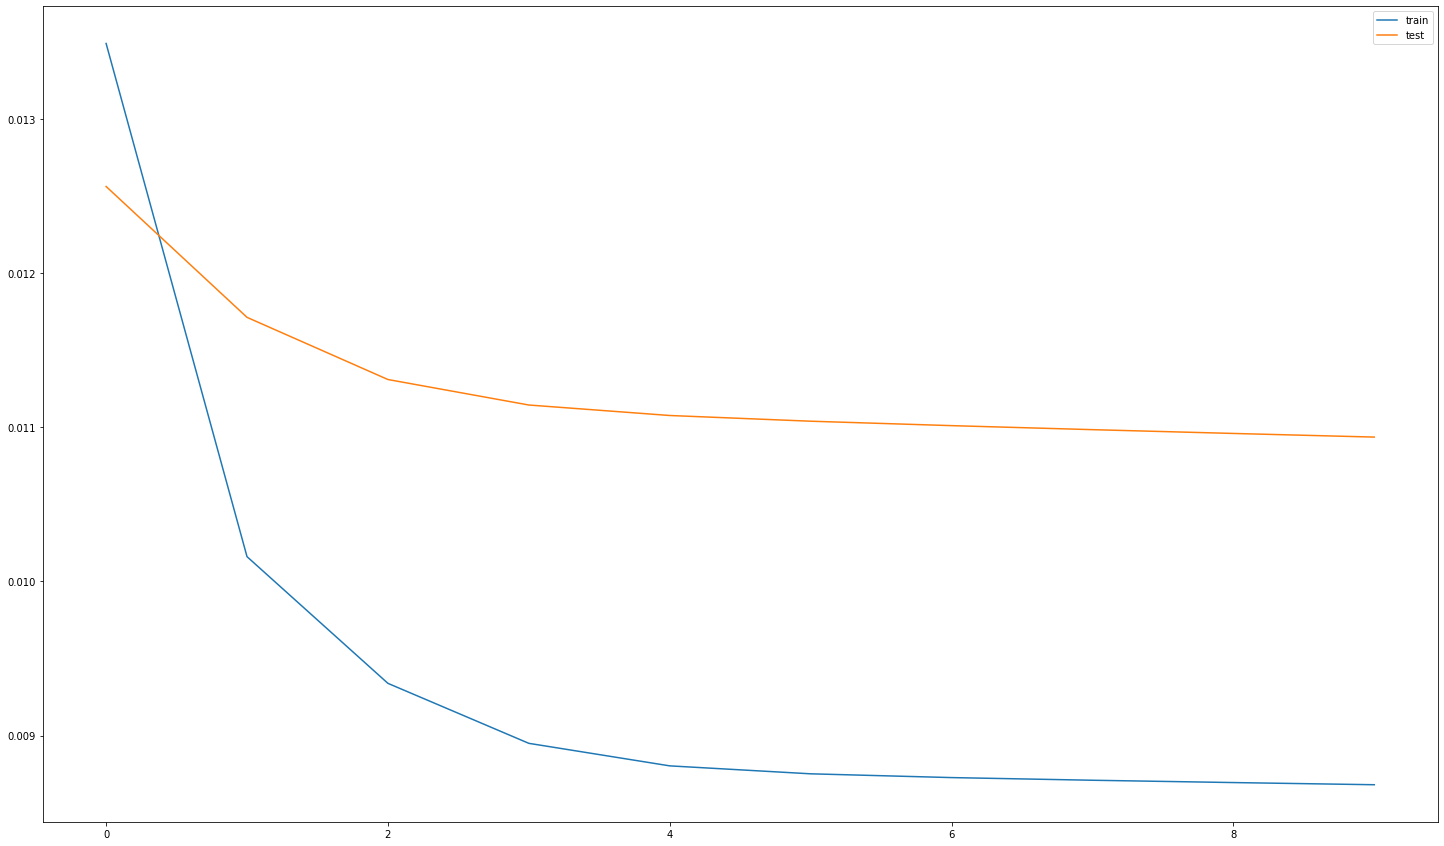

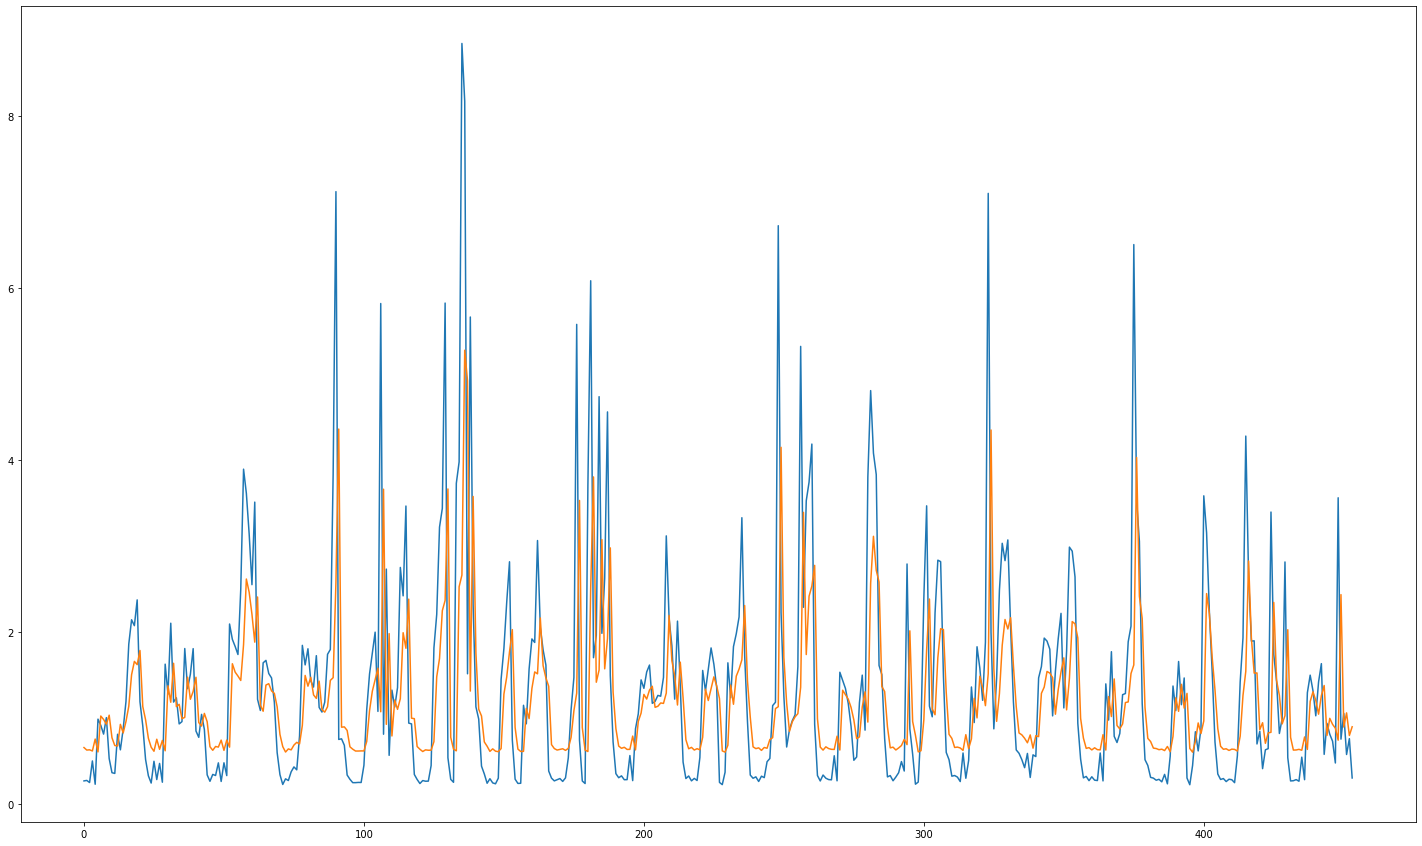

The RMSE in the train set is: 1.0017745746867257
The RMSE in the test set is: 1.1178680077348886


In [356]:
for home in homes: 
    run_model(homes[home], train_size=0.9, epochs=10)

In [357]:
rmse_test

{'single_total_a': 0.24900272961725892,
 'single_total_b': 0.6708378948110469,
 'single_total_c': 0.8083240626243448,
 'single_total_d': 2.740319521861948,
 'single_total_f': 5.139614918251073,
 'single_total_g': 3.3394041076093184,
 'single_total_h': 1.1178680077348886}

In [257]:
remes_single = {}

remes_single = np.sqrt(mean_squared_error(pred_test['true_total_a'],pred_test['simple_lstm_total_a']))

## Single Conv training

In [369]:
for home in homes:
     run_conv_model(homes[home], train_size=0.9, epochs=10, plot=False)

(15851, 1, 1)
Epoch 1/10
248/248 [==============================] - 1s 3ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 2/10
248/248 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 3/10
248/248 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 4/10
248/248 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 5/10
248/248 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 6/10
248/248 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 7/10
248/248 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 8/10
248/248 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 9/10
248/248 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/10
248/248 [==============================] - 1s 3ms/step - loss: 0.0058 - va

In [474]:
pd.DataFrame.from_dict(rmse_test, orient='index').to_csv("results_singleconv.csv")